# Captsone Project - Starbucks Offers
## Introduction
The data for this project was provided by Starbucks for the Udacity Data Scientist Nanodegree program.  It is simulated (rather than actual) data that mimics reward offers and customer purchasing behavior over a 30-day test period.

There are three questions that I would like to answer in this project:
1. What are the demographic groups?
2. Which offer is best for each demographic group?
3. Which delivery method is best for each offer/demographic group?

Three datasets are provided:

**portfolio.json**

Offers sent during a 30-day test period
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**

Rewards program users
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**

Event log
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import progressbar
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [197]:
# read in datasets
portfolio = pd.read_json('data/portfolio.json',orient='records',lines=True)
profile = pd.read_json('data/profile.json',orient='records',lines=True)
transcript = pd.read_json('data/transcript.json',orient='records',lines=True)

In [198]:
# Preview each dataframe and display the shape
display(portfolio.head())
print('portfolio shape:',portfolio.shape)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


portfolio shape: (10, 6)


In [199]:
display(profile.head())
print('profile shape:',profile.shape)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


profile shape: (17000, 5)


In [200]:
display(transcript.head())
print('transcript shape:',transcript.shape)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


transcript shape: (306534, 4)


## Data Exploration
Exploring the **portfolio** dataframe is easy because there are only 10 rows and 6 columns so the entire dataframe can be easily visualized.

In [201]:
# display the entire portfolio dataframe
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


There are 10 different offers: 4 bogo's, 4 discounts, and 2 informational types.  All of them use email as a channel, which means that including email doesn't provide a way to distinguish any of the offer types.  I can drop this value from the 'channels' feature to simplify the analysis.

For the **profile** dataframe, lets first look at null values.  Missing values in 'age' are represented by the value 118, while in 'gender' they are represented by the string 'None'.  I will map these values to NaN's and then count the null values in each column.

In [202]:
# Map 118 to NaN in 'Age' column
profile['age'] = profile['age'].apply(lambda x: np.nan if x==118 else x)

In [203]:
profile.head()

,age,became_member_on,gender,id,income
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [204]:
# Map 'None' to NaN in 'gender column'
profile['gender'] = profile['gender'].apply(lambda x: np.nan if x==None else x)
profile.head()

,age,became_member_on,gender,id,income
0,NaN,20170212,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,20180712,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,20170804,NaN,a03223e636434f42ac4c3df47e8bac43,NaN


In [205]:
# count the number of null values in each column of the profile dataframe
profile.isnull().sum()

age                 2175
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [206]:
# now count the number of rows with 3 null values
profile.isnull().sum(axis=1).value_counts()

0    14825
3     2175
dtype: int64

Of the 17,000 users in the **profile** dataset, 2,175 are missing age, gender, and income data while the remaining 14,825 users are not missing any demographic data.  The only identifying feature for the 2,175 users is the date they joined the Starbucks rewards program.  This could be a useful feature later in the analysis, but if it isn't, then I'll feel confident dropping the users with missing values since I'll still have a majority of the dataset with complete information.

I also want to visualize the demographic data and calculate some descriptive statistics for each demographic feature.

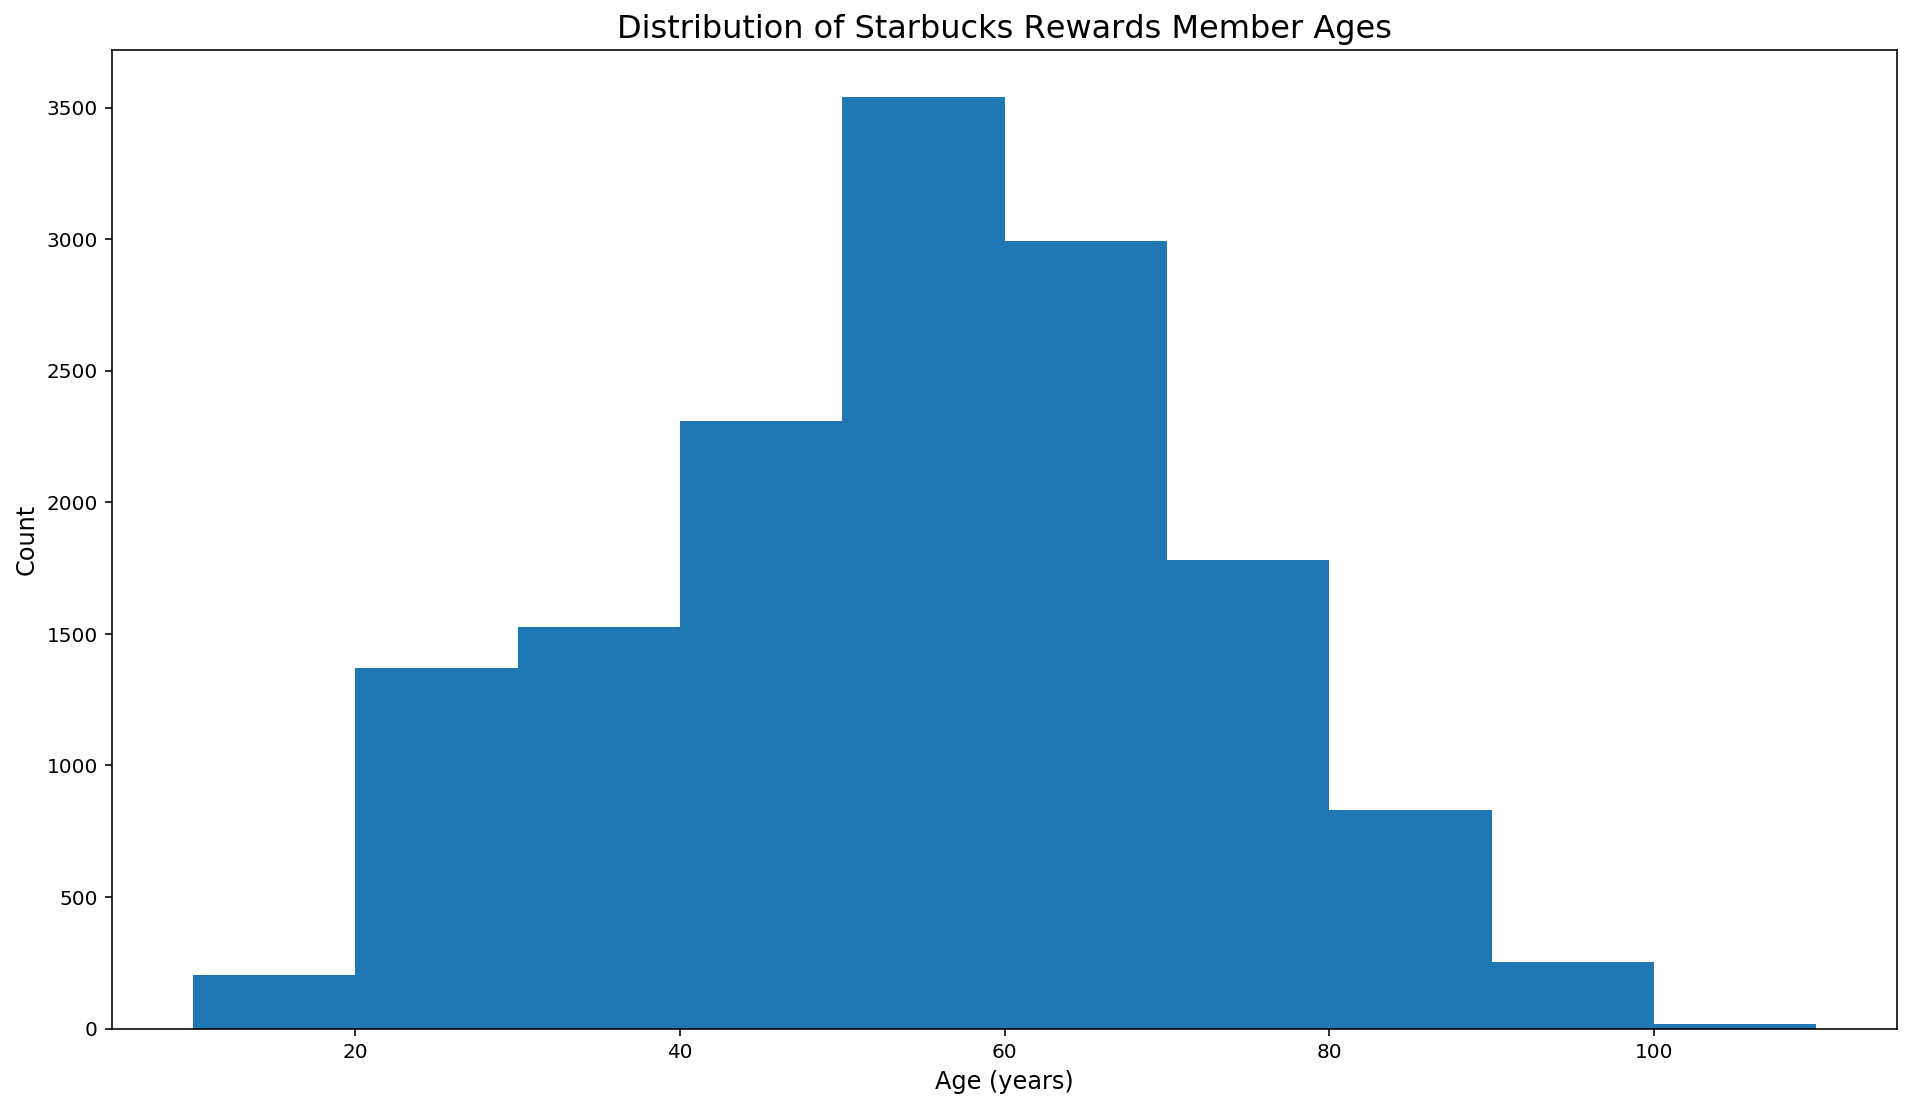

In [207]:
# plot a histogram of the 'age' feature
fig, ax = plt.subplots(figsize=(16,9))
ax.hist(profile['age'],bins=range(10,120,10))
ax.set_xlabel('Age (years)',fontsize=12)
ax.set_ylabel('Count',fontsize=12)
ax.set_title('Distribution of Starbucks Rewards Member Ages',fontsize=16)
plt.show()

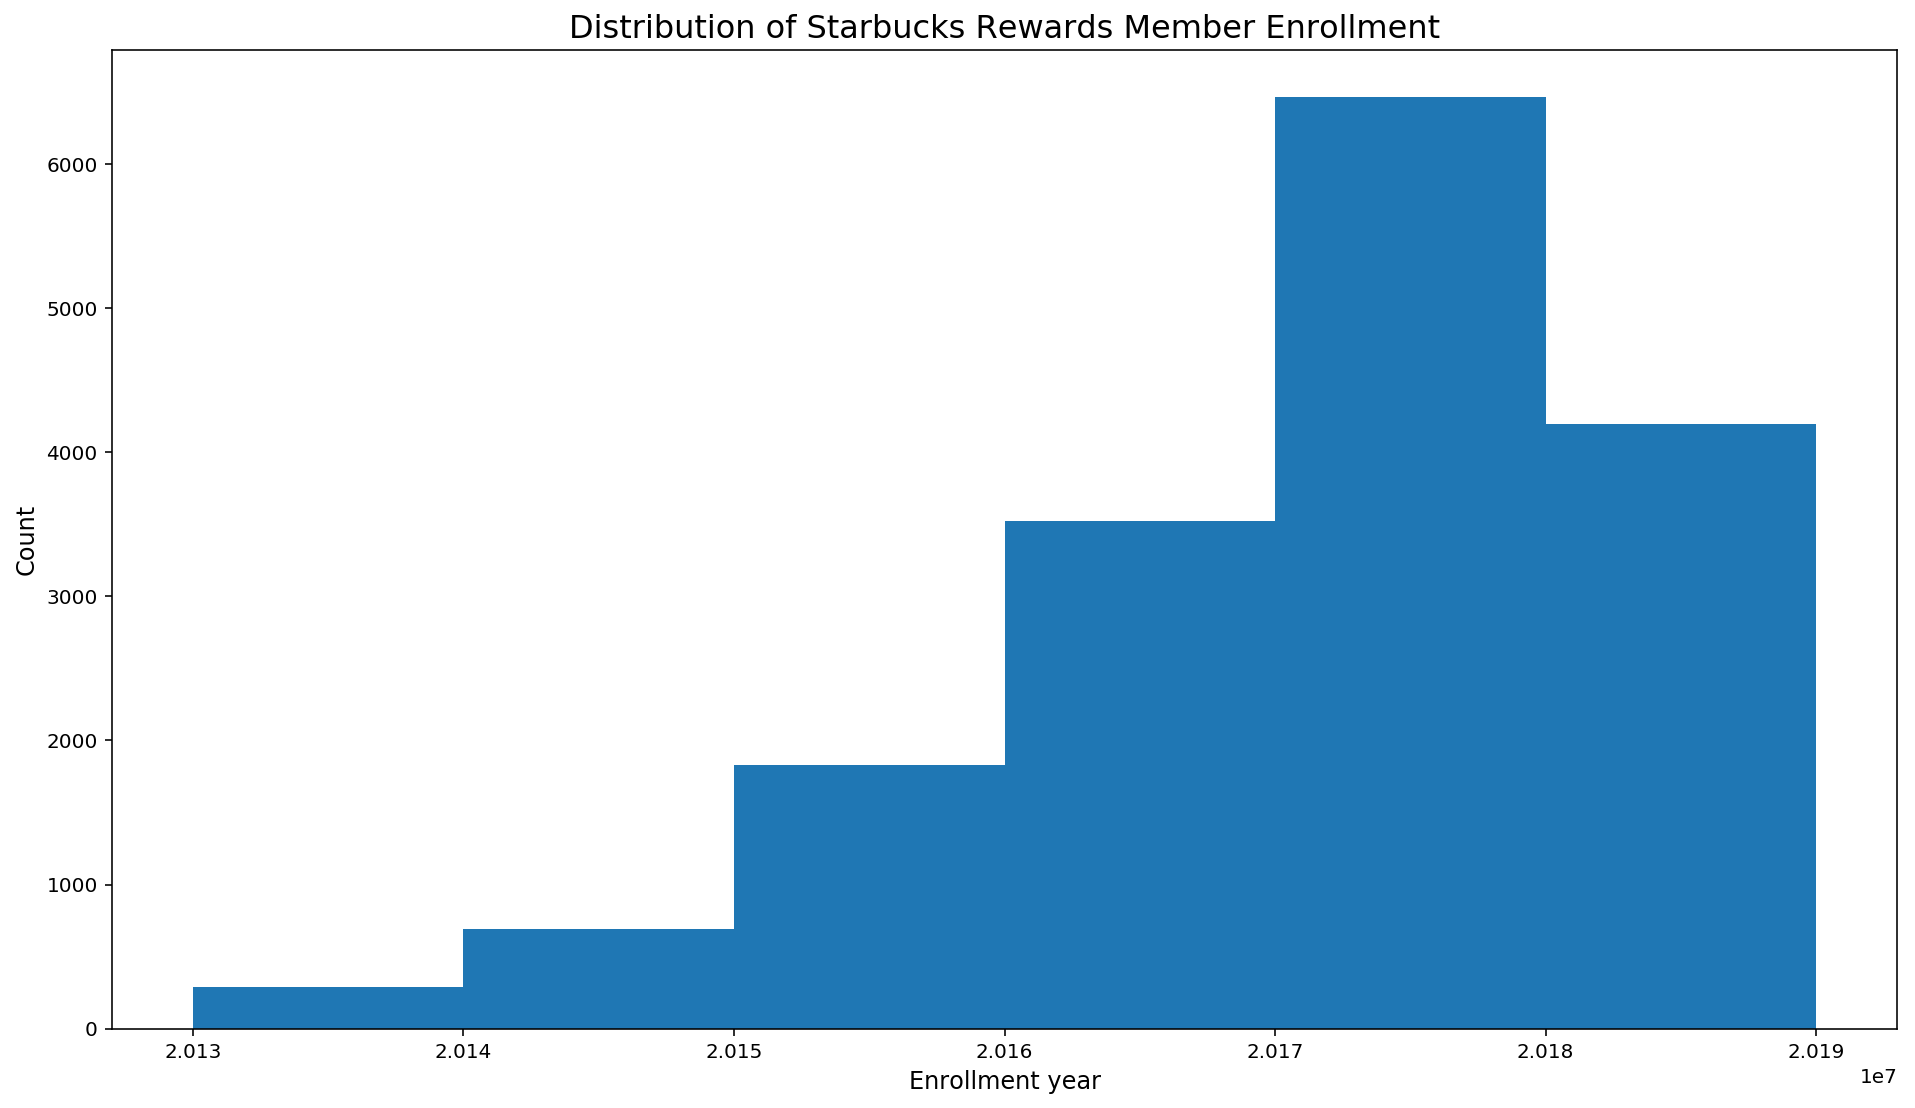

In [208]:
# plot a histogram of the 'became_member_on' feature
fig, ax = plt.subplots(figsize=(16,9))
ax.hist(profile['became_member_on'],bins=range(20130000,20200000,10000))
ax.set_xticks(range(20130000,20200000,10000))
ax.set_xlabel('Enrollment year',fontsize=12)
ax.set_ylabel('Count',fontsize=12)
ax.set_title('Distribution of Starbucks Rewards Member Enrollment',fontsize=16)
plt.show()

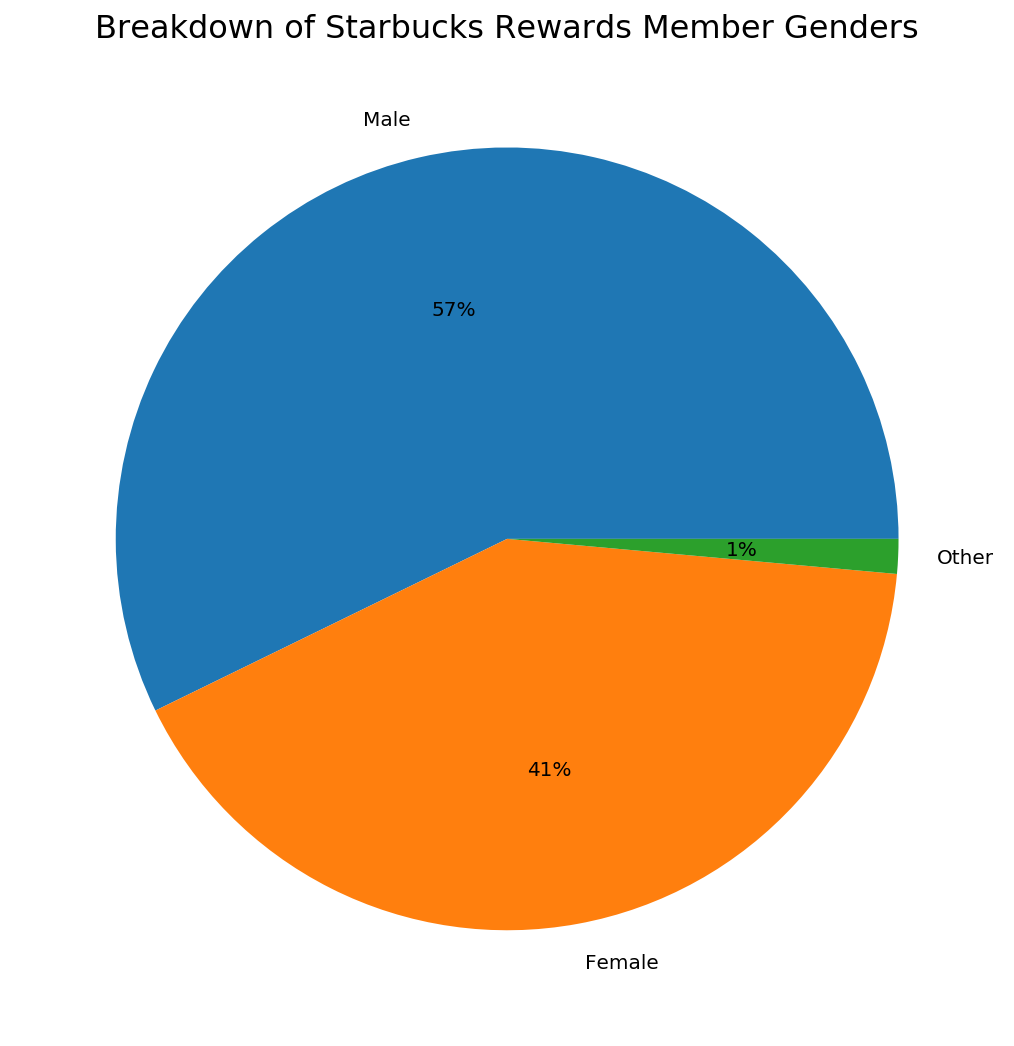

In [209]:
# plot a pie chart of the 'gender' feature
gender_labels = profile['gender'].value_counts().index.map({'M':'Male','F':'Female','O':'Other'})
fig, ax = plt.subplots(figsize=(16,9))
ax.pie(profile['gender'].value_counts(),labels=gender_labels,autopct='%1.f%%')
ax.set_title('Breakdown of Starbucks Rewards Member Genders',fontsize=16)
plt.show()

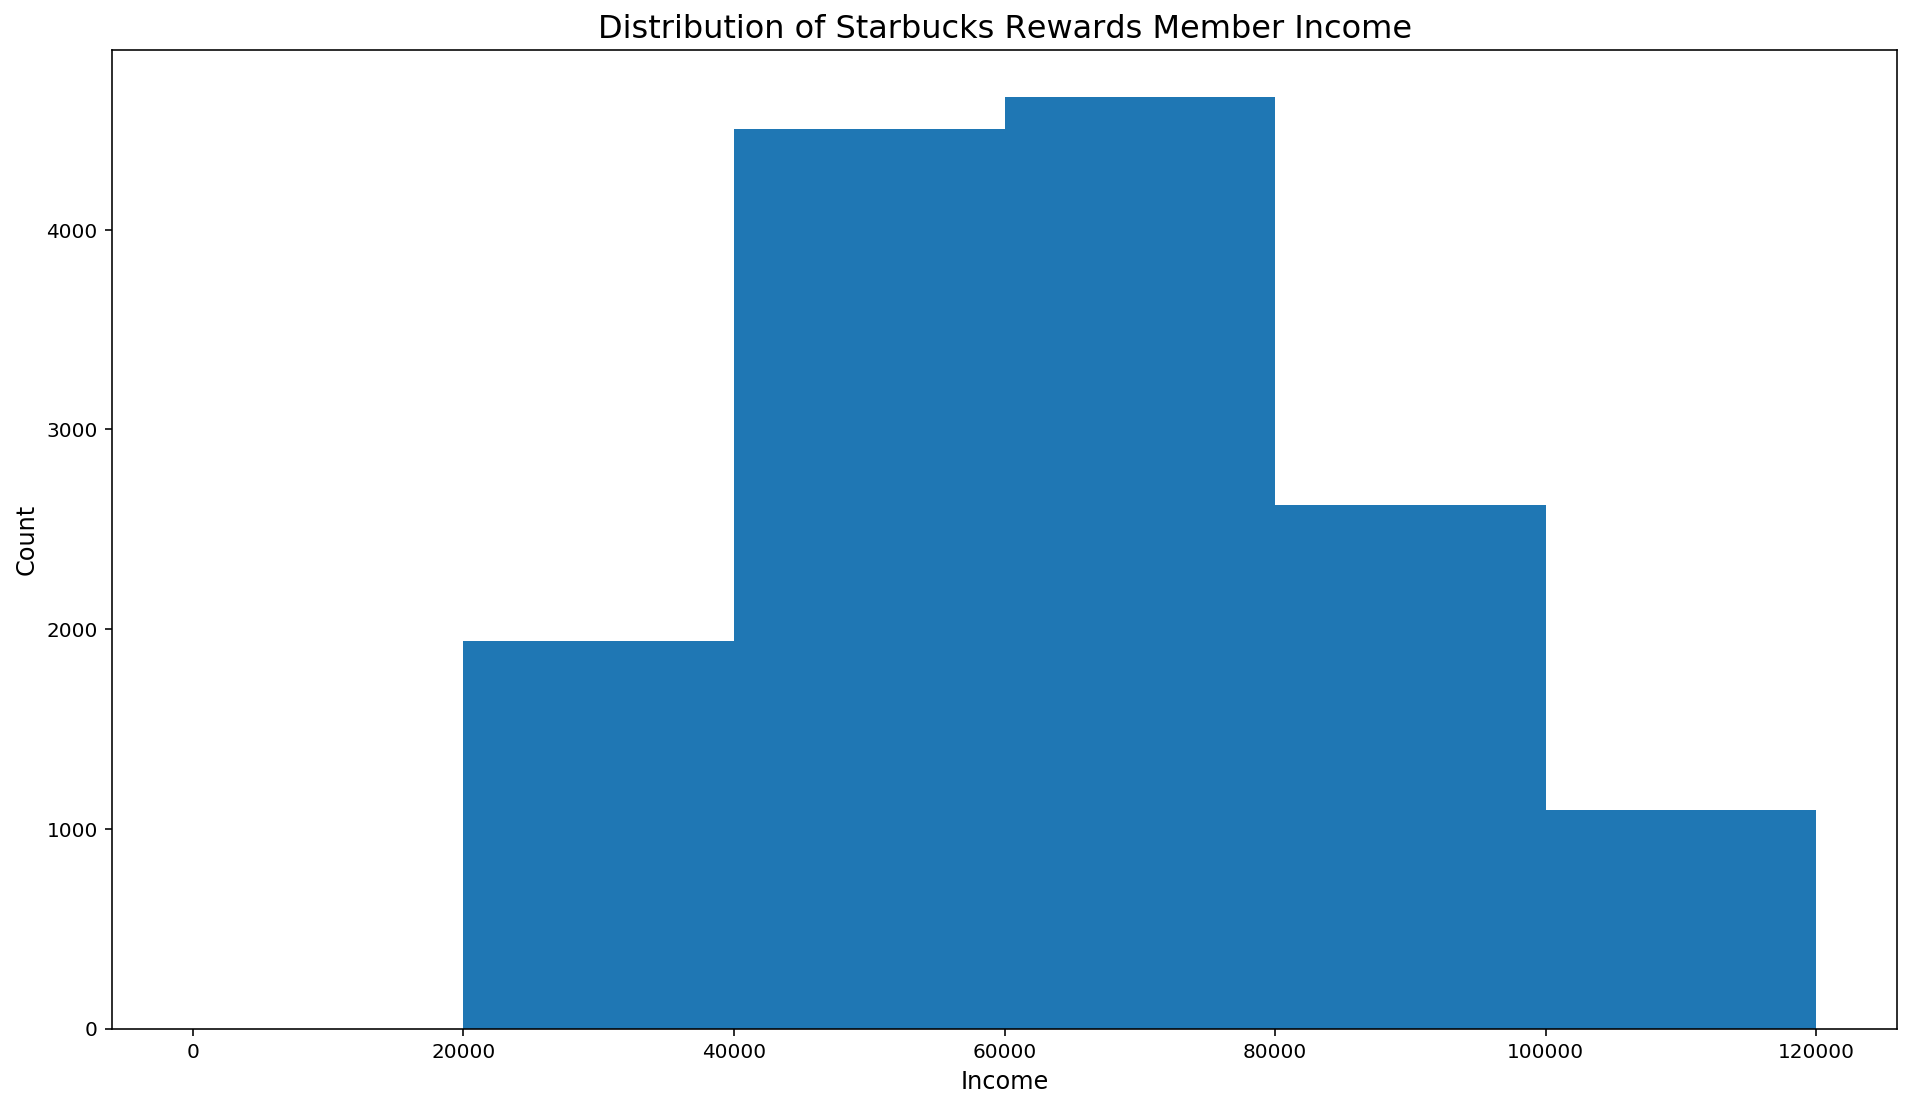

In [210]:
fig, ax = plt.subplots(figsize=(16,9))
ax.hist(profile['income'],bins=range(0,140000,20000))
ax.set_xlabel('Income',fontsize=12)
ax.set_ylabel('Count',fontsize=12)
ax.set_title('Distribution of Starbucks Rewards Member Income',fontsize=16)
plt.show()

In [211]:
# Generate descriptive statistics of the demographic data
profile.describe()

,age,became_member_on,income
count,14825.000000,1.700000e+04,14825.000000
mean,54.393524,2.016703e+07,65404.991568
std,17.383705,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016053e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


Visualizations and descriptive statistics of the demographic data in the **profile** dataset have given me a better understanding of the makeup of this user group.  The rewards members range in age from 18 to 101 years with a mean age of ~54 years.  The minimum age makes sense since it is likely an individual must be 18 years or older to join the rewards program, but I am a little surprised that there is a 101-year-old member and that the age distribution is centered around 55.  I expected the distribution to be centered around users in their 20s and 30s.  Member incomes range from $14,825 to $120,000 with a mean of ~$65,400, which falls in line with my expectations for income distribution in the U.S.  A majority (57\%) of members are male, which also surprised me since I expected it to be closer to a 50/50 split with female or skewed towards female consumers.  Finally, membership enrollment ranges from July 2013 to July 2018 with enrollment numbers increasing at an increasing rate from 2013 through 2017 before decreasing in 2018.  The decrease in 2018 is likely due to capturing an incomplete year of member enrollments.  This trend in enrollments indicates that the Starbucks Rewards program is increasing in popularity and therefore there is an opportunity to influence the purchasing behavior of a growing number of Starbucks customers with this project.

For the **transcript** dataset, I don't expect there to be any missing data since these records were generated during the experiment and should have been set up to record all relevant information.

In [212]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

As expected, there are no missing values in the **transcript** dataset.  To better understand the data in this dataset, I will have to use different exploration techniques than those used on the **profile** dataset since most of those features were continuous numerical or categorical types.

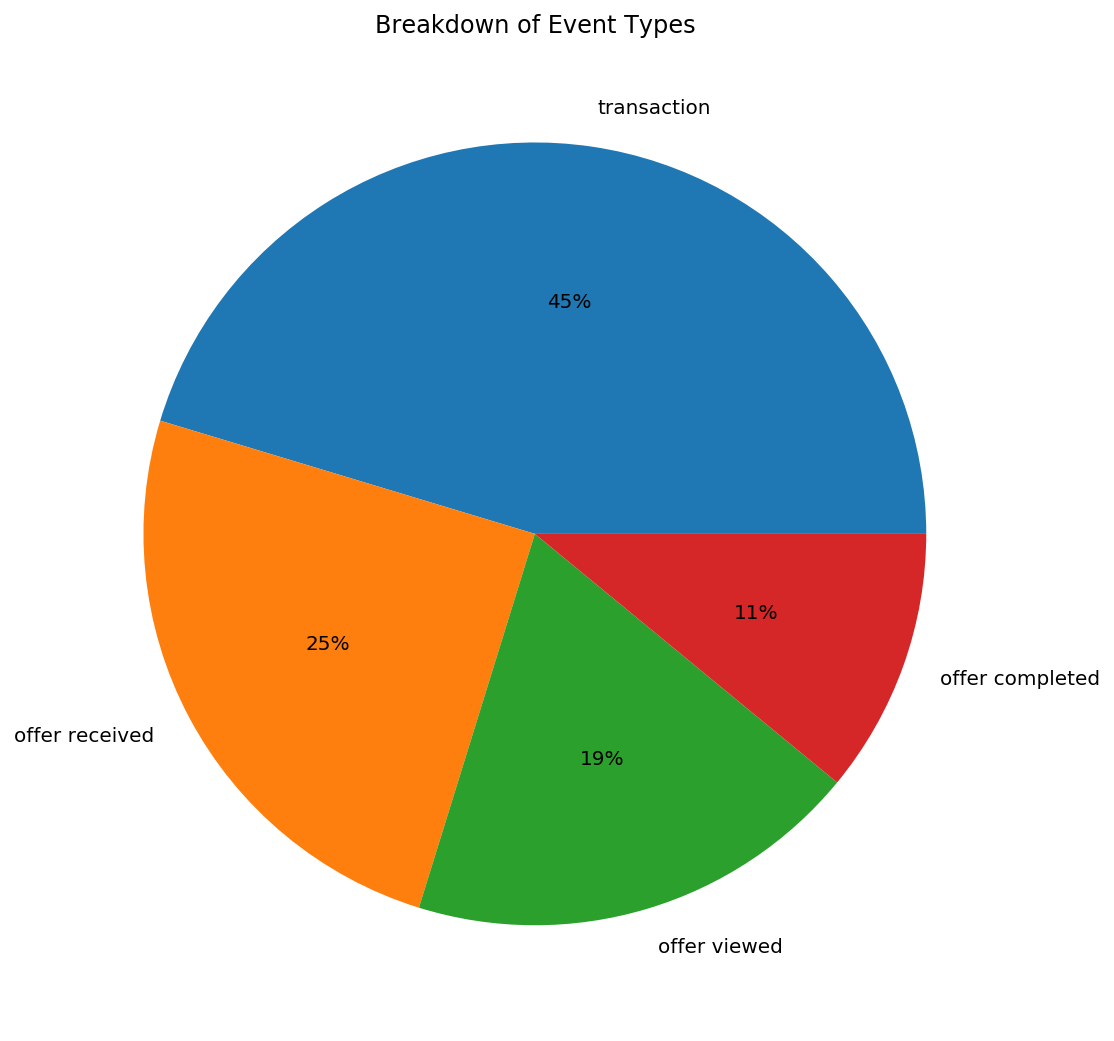

In [213]:
# plot a pie chart of the 'event' feature
fig, ax = plt.subplots(figsize=(16,9))
ax.pie(transcript['event'].value_counts(),labels=transcript['event'].value_counts().index,autopct='%1.f%%')
ax.set_title('Breakdown of Event Types')
plt.show()

In [214]:
# determine the number of unique members in the transcript dataframe
n_members = len(np.unique(transcript['person']))
print('{} members had an event captured in the transcript dataset'.format(n_members))

17000 members had an event captured in the transcript dataset


In [215]:
# group the transcript dataframe by 'person'
transcript_grouped = transcript.groupby('person')

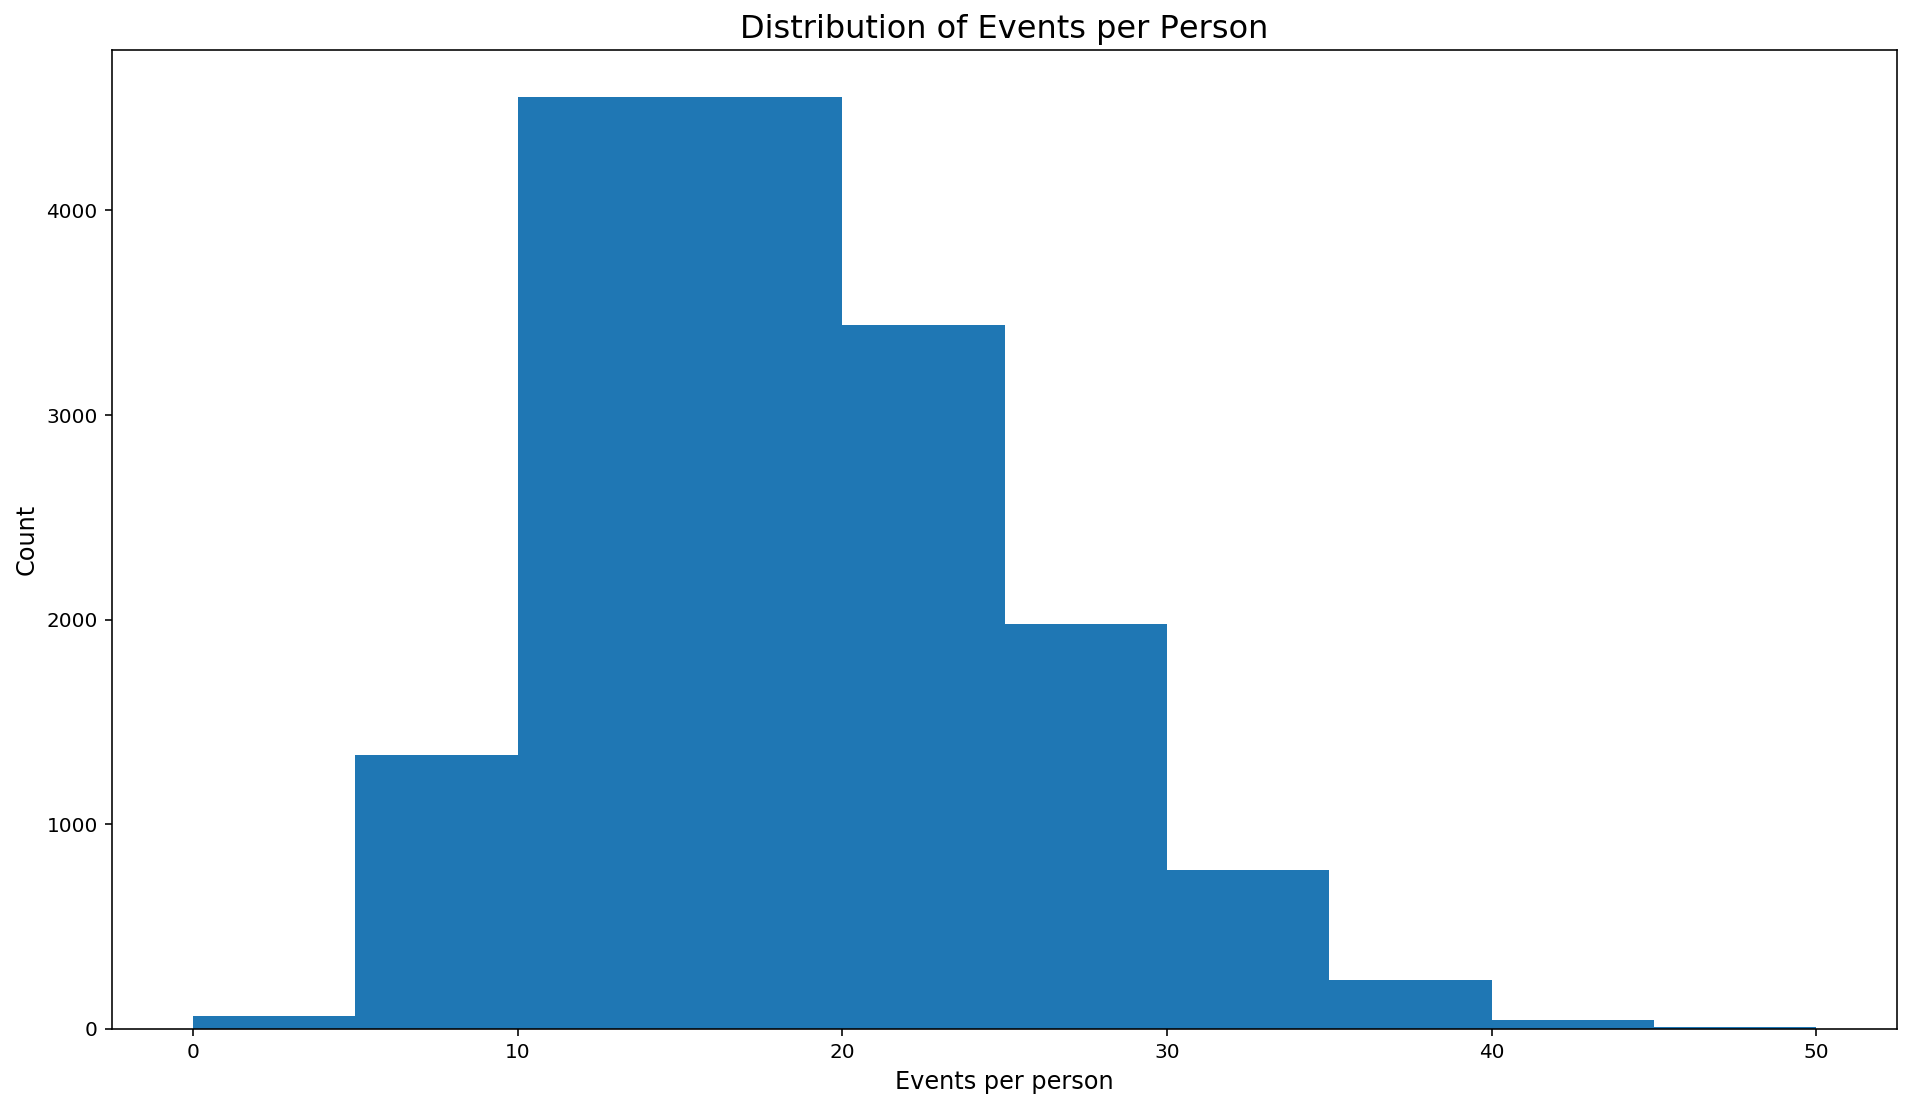

In [216]:
# plot distribution of events per person
fig, ax = plt.subplots(figsize=(16,9))
ax.hist(transcript_grouped['event'].count(),bins=range(0,55,5))
ax.set_xlabel('Events per person',fontsize=12)
ax.set_ylabel('Count',fontsize=12)
ax.set_title('Distribution of Events per Person',fontsize=16)
plt.show()

In [217]:
# generate descriptive statistics on the events per person
transcript_grouped['event'].count().describe()

count    17000.000000
mean        18.031412
std          6.849595
min          1.000000
25%         13.000000
50%         17.000000
75%         23.000000
max         51.000000
Name: event, dtype: float64

In [218]:
# confirm that all of the customers in the 'transcript' dataframe are also in the 'profile' dataframe
print('Number of users that are in the transcript dataset but not the profile dataset:',len(np.setdiff1d(np.unique(transcript['person']),profile['id'])))

Number of users that are in the transcript dataset but not the profile dataset: 0


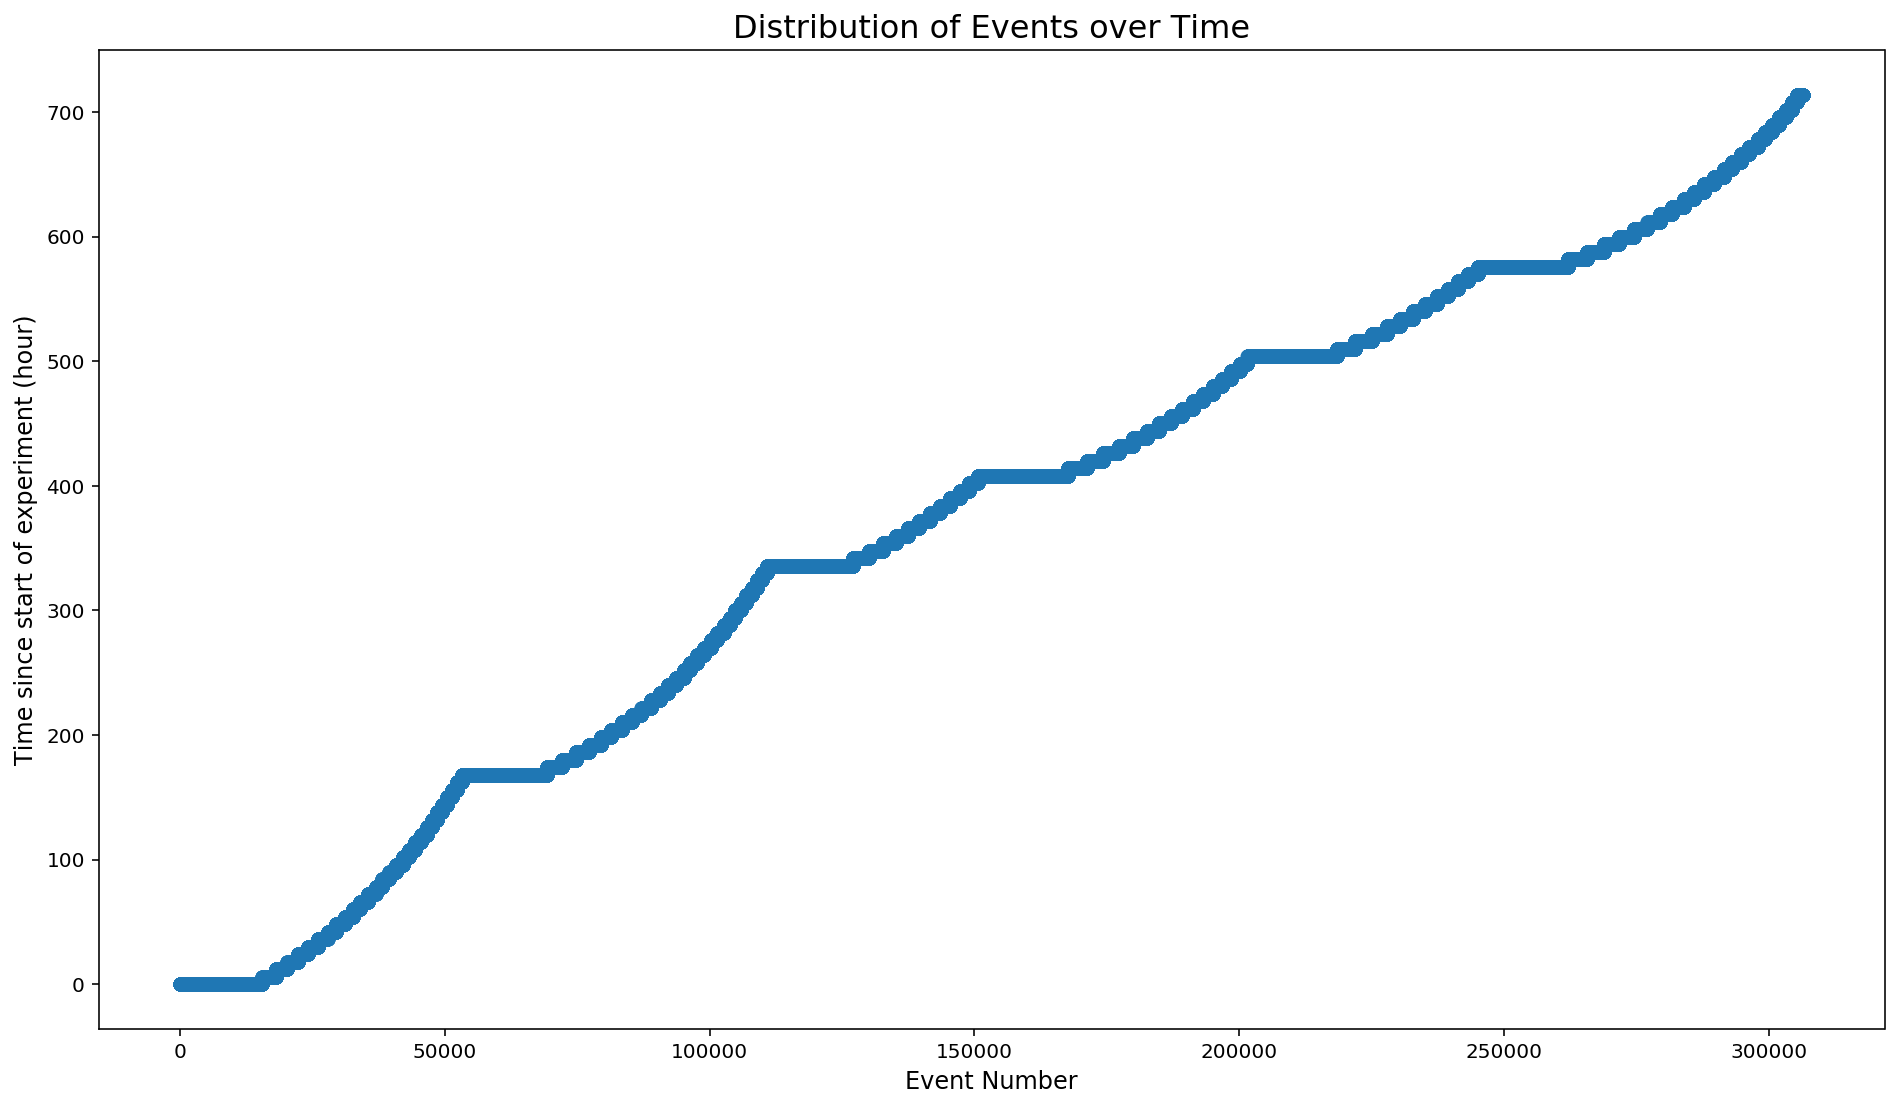

In [219]:
# plot distribution of events per person
fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(transcript.index,transcript['time'])
ax.set_xlabel('Event Number',fontsize=12)
ax.set_ylabel('Time since start of experiment (hour)',fontsize=12)
ax.set_title('Distribution of Events over Time',fontsize=16)
plt.show()

The **transcript** dataset is broken up fairly evenly between transactions (45%) and reward-based events consisting of offers received (25%), viewed (19%), and completed (11%).  Based on the percentages, I noticed that approximately 80% of the rewards that were received were also viewed (19%/25%), and less than half (11%/25%) were completed.  Each user had at least 1 event, and all of the users recorded in the **transcript** dataset are also in the **profile** dataset.  Finally, the distribution of events over time shows a large number of events occurring in a single hour periodically throughout the 30-day experimental period.  These periods of activity probably correspond with the distribution new reward offers, which can happen simultaneously if they are generated automatically.  The way these reward offers are distributed in groups may serve to break up the experiment into multiple segments.  This raises the question: are new offers only sent out after the previous offers expired? Or is there overlap between offers for a given customer?  I will investigate this.

## Data Cleaning
Now that I better understand the data that I am working with, I will clean it to make it easier to work with.  This includes one hot encoding categorical features, extracting data from lists or dictionaries within the datasets, converting strings to dates and times, and remapping reward and member ids to something that is easier to comprehend.

In [220]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [221]:
# one hot encode the 'offer_type' feature of the 'portfolio' dataset
portfolio = pd.get_dummies(portfolio,prefix='',prefix_sep='',columns=['offer_type'])
portfolio

,channels,difficulty,duration,id,reward,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,0,1,0
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,0,1
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,0,0
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,2,0,1,0


To one hot encode the 'channels' feature, I can't use `get_dummies` because there are multiple entries in each row.  I will have to iterate through each row and manually assign values instead.

In [222]:
# create a list of all options for 'channels' (easy to do visually/manually in a small df)
channel_list = ['web','email','mobile','social']

In [274]:
# write a function to encode the channels in 'channels' into separate columns
def encode_column(df,column,col_list):
    '''
    One hot encodes a column of a dataframe when multiple entries occur in a single column
    Drops the original column once encoding is done
    
    Inputs
    df (pandas dataframe): the dataframe on which to perform the encoding
    column (string): name of the column to encode
    col_list (list): all values which can be in 'column'
    
    Returns
    df (pandas dataframe): the original df with encoded columns and without the original column
    '''
    for col in col_list: # loop through the list of values in column
        df.loc[:,col] = 0 # initialize each new column with 0's
    # create progress bar to track progress
    bar = progressbar.ProgressBar(maxval=len(df.index),widgets=[progressbar.Bar('=','[',']',' '),' ',progressbar.Percentage()])
    bar.start()
    cter = 1
    for idx in df.index: # loop through the indices of the df
        for value in df.loc[idx,column]:
            df.loc[idx,value] = 1 # assign a value of 1 to the corresponding index,column that corresponds to 'value'
        bar.update(cter) # update progress bar
        cter += 1 # update counter
    bar.finish()
    
    # drop the original column
    df = df.drop(columns=column)
    return df

In [224]:
# run the 'encode_column' function on the 'channels' column in 'portfolio' df and assign to 'portfolio_encoded'
portfolio_encoded = encode_column(portfolio,'channels',channel_list)

# view new 'portfolio_encoded' df
portfolio_encoded

,difficulty,duration,id,reward,bogo,discount,informational,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,0,1,0,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,0,1,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,0,0,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,0,1,0,1,1,1,0


In [225]:
# since every reward can be delivered via email, this does not add any information to the analysis
# I will drop the 'email' column
portfolio_encoded.drop(columns='email',inplace=True)

The final bit of cleaning I will perform on the **portfolio** dataset is more cosmetic than functional.  I will replace the 32 character alphanumeric 'id' with an integer value and group them by reward type.  This will make it easier for me to quickly refer to the reward ids later in the analysis.

In [226]:
# sort the 'portfolio_encoded' df so that it is grouped by reward type, then increasing diffulty and duration
portfolio_encoded.sort_values(by=['bogo','discount','informational','difficulty','duration'],
                              ascending=[False,False,False,True,True],inplace=True)
portfolio_encoded

,difficulty,duration,id,reward,bogo,discount,informational,web,mobile,social
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,0,0,1,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,0,1,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,0,1,0,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,0,1,0,1,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0,1,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,0,1,0,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,1,1,0


In [227]:
def id_mapper(df,column):
    '''
    Create a dictionary with keys corresponding to original ids and values corresponding to new integer ids
    
    Inputs
    df (pandas dataframe): the dataframe containing ids to remap
    column (string): the name of the id column
    
    Returns
    id_dict (dict): dictionary with 
    '''
    id_dict = {}
    counter = 1 # initialize counter for reward_ids
    for _id in df[column]:
        if _id not in id_dict.keys():
            id_dict[_id] = counter
            counter+=1
    return id_dict

In [228]:
# create the dictionary for reward ids
reward_id_dict = id_mapper(portfolio_encoded,'id')

# view the reward_id dictionary
reward_id_dict

{'f19421c1d4aa40978ebb69ca19b0e20d': 1,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 2,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 3,
 'ae264e3637204a6fb9bb56bc8210ddfd': 4,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 5,
 '2906b810c7d4411798c6938adc9daaa5': 6,
 'fafdcd668e3743c1bb461111dcafc2a4': 7,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 8,
 '5a8bc65990b245e5a138643cd4eb9837': 9,
 '3f207df678b143eea3cee63160fa8bed': 10}

In [229]:
def map_id_column(df,old_col,new_col,id_dict):
    '''
    Creates a new column in a dataframe with values based on the values in an existing column and a mapping dictonary
    Drops the existing column
    
    Inputs
    df (pandas dataframe): the dataframe containing the column to map
    old_col (string): the name of the existing column
    new_col (string): the name of the new column to create
    id_dict (dict): dictionary with old_col entries as keys and new_col entries as values
    
    Returns
    df (pandas dataframe): the original df with the new column added and the old column dropped
    '''
    df[new_col] = df[old_col].apply(lambda x: id_dict.get(x,0)) # create new column with values mapped from the old column
    df.drop(columns=old_col,inplace=True) # drop the old column
    
    return df

In [230]:
portfolio_encoded = map_id_column(portfolio_encoded,'id','reward_id',reward_id_dict)
portfolio_encoded

,difficulty,duration,reward,bogo,discount,informational,web,mobile,social,reward_id
8,5,5,5,1,0,0,1,1,1,1
3,5,7,5,1,0,0,1,1,0,2
1,10,5,10,1,0,0,1,1,1,3
0,10,7,10,1,0,0,0,1,1,4
5,7,7,3,0,1,0,1,1,1,5
9,10,7,2,0,1,0,1,1,0,6
6,10,10,2,0,1,0,1,1,1,7
4,20,10,5,0,1,0,1,0,0,8
7,0,3,0,0,0,1,0,1,1,9
2,0,4,0,0,0,1,1,1,0,10


In [231]:
# create an inverse dictionary mapper in case I want to access the original ids
def id_mapper_inverse(id_dict):
    '''
    Creates an inverse dictionary where the keys become the values and the values become the keys
    
    Input
    id_dict (dict): the original dictionary to invert
    
    Returns
    id_dict_inv (dict): the inverted dictionary
    '''
    id_dict_inv = {} # initialize dictionary
    for key, value in id_dict.items(): # loop through the key-value pairs
        id_dict_inv[value] = key # assign the value as the key and the key as the value of the inverse dictionary
    
    return id_dict_inv

In [232]:
# test the id_mapper_inv function on the reward_id_dict
reward_id_dict_inv = id_mapper_inverse(reward_id_dict)
reward_id_dict_inv

{1: 'f19421c1d4aa40978ebb69ca19b0e20d',
 2: '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 3: '4d5c57ea9a6940dd891ad53e9dbe8da0',
 4: 'ae264e3637204a6fb9bb56bc8210ddfd',
 5: '2298d6c36e964ae4a3e7e9706d1fb8c2',
 6: '2906b810c7d4411798c6938adc9daaa5',
 7: 'fafdcd668e3743c1bb461111dcafc2a4',
 8: '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 9: '5a8bc65990b245e5a138643cd4eb9837',
 10: '3f207df678b143eea3cee63160fa8bed'}

The **portfolio** dataset now consists of only numeric values.  The reward_ids are grouped in a way the I can remember and quickly refer to later:

* **BOGO** offers are ids **1-4** with increasing difficulty and duration
* **Discount** offers are ids **5-8** with increasing difficulty and duration
* **Informational** offers are ids **9-10** with increasing duration

I have already handled the missing values in the **profile** dataset.  Now I will convert the enrollment date ('became_member_on') string to a date object and a timestamp and map the alphanumeric 'id' to a numeric user_id.

In [291]:
# convert 'became_member_on' string to date object
profile['enrollment_date'] = profile['became_member_on'].apply(lambda x: datetime.strptime(str(x),'%Y%m%d').date())
profile['enrollment_tstamp'] = profile['became_member_on'].apply(lambda x: datetime.strptime(str(x),'%Y%m%d').timestamp())
profile.head()

,age,became_member_on,gender,id,income,enrollment_date,year,enrollment_tstamp
0,NaN,20170212,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017-02-12,2017,1.486879e+09
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,2017,1.500095e+09
2,NaN,20180712,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018-07-12,2018,1.531372e+09
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,2017,1.494306e+09
4,NaN,20170804,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,2017-08-04,2017,1.501823e+09


In [293]:
# one hot encode 'gender' column
profile_encoded = pd.get_dummies(profile,columns=['gender'])
# drop the 'became_member_on' column
profile_encoded.drop(columns='became_member_on',inplace=True)
# preview df
profile_encoded.head()

,age,id,income,enrollment_date,year,enrollment_tstamp,gender_F,gender_M,gender_O
0,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017-02-12,2017,1.486879e+09,0,0,0
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,2017,1.500095e+09,1,0,0
2,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018-07-12,2018,1.531372e+09,0,0,0
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,2017,1.494306e+09,1,0,0
4,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,2017-08-04,2017,1.501823e+09,0,0,0


In [294]:
# sort the profile dataset by enrollment date then use the id_mapper function
member_id_dict = id_mapper(profile_encoded.sort_values(by=['enrollment_date','age']),'id')

profile_encoded = map_id_column(profile_encoded,'id','member_id',member_id_dict)
profile_encoded.head()

,age,income,enrollment_date,year,enrollment_tstamp,gender_F,gender_M,gender_O,member_id
0,NaN,NaN,2017-02-12,2017,1.486879e+09,0,0,0,6730
1,55.0,112000.0,2017-07-15,2017,1.500095e+09,1,0,0,8198
2,NaN,NaN,2018-07-12,2018,1.531372e+09,0,0,0,16717
3,75.0,100000.0,2017-05-09,2017,1.494306e+09,1,0,0,7566
4,NaN,NaN,2017-08-04,2017,1.501823e+09,0,0,0,8579


In [295]:
# create an inverse member_id dictionary
member_id_dict_inv = id_mapper_inverse(member_id_dict)

For the **transcript** dataset, I need to one hot encode the 'event' column, map the 'person' column to the numeric 'member_id' using the member_id dictionary, and extract the values from the dictionaries in the 'value' column.

In [143]:
# replace spaces with underscores in 'event' column
transcript['event'] = transcript['event'].apply(lambda x: x.replace(' ','_'))
# one hot encode the 'event' column
transcript_encoded = pd.get_dummies(transcript,prefix='',prefix_sep='',columns=['event'])

# preview the new df
transcript_encoded.head()

,person,time,value,offer_completed,offer_received,offer_viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0


In [144]:
# map the alphanumeric 'person' column to 'member_id'
transcript_encoded = map_id_column(transcript_encoded,'person','member_id',member_id_dict)
transcript_encoded.head()

,time,value,offer_completed,offer_received,offer_viewed,transaction,member_id
0,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,7566
1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,8579
2,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0,15235
3,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0,10036
4,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0,10235


In [145]:
# identify all possible options for keys in the 'value' column
value_set = set() # initialize an empty set
for row in transcript_encoded['value']: # loop through the 'value' column
    for key in row.keys():
        value_set.add(key) # add the key from each dictionary to the set

# view the set
value_set

{'amount', 'offer id', 'offer_id', 'reward'}

In [146]:
# create new columns for the keys in the 'value' column
for col in list(value_set):
    transcript_encoded[col] = 0 # initialize them with 0's
    
transcript_encoded.head()

,time,value,offer_completed,offer_received,offer_viewed,transaction,member_id,offer_id,amount,reward,offer id
0,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,7566,0,0,0,0
1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,8579,0,0,0,0
2,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0,15235,0,0,0,0
3,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0,10036,0,0,0,0
4,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0,10235,0,0,0,0


In [147]:
# # loop through the indices and assign the values in the 'value' dictionaries to the columns matching the keys
# # use a progress bar to track progress (takes a while)
# bar = progressbar.ProgressBar(maxval=transcript_encoded.index[-1],widgets=[progressbar.Bar('=','[',']',' '),' ',progressbar.Percentage()])
# bar.start()
# for idx in transcript_encoded.index:
#     value_dict = transcript_encoded.loc[idx,'value']
#     for key, value in value_dict.items():
#         transcript_encoded.loc[idx,key] = value
#     bar.update(idx)
    
# bar.finish()

In [148]:
# # save the dataframe in a pickle file to skip the previous step in future runs
# pickle.dump(transcript_encoded,open('transcript_encoded.p','wb'))

In [149]:
# check that the pickle file can load properly
transcript_encoded = pickle.load(open('transcript_encoded.p','rb'))

# preview the dataframe loaded from the pickle file
transcript_encoded.head()

,time,value,offer_completed,offer_received,offer_viewed,transaction,member_id,amount,offer_id,reward,offer id
0,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,7566,0.0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,8579,0.0,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0,15235,0.0,0,0,2906b810c7d4411798c6938adc9daaa5
3,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0,10036,0.0,0,0,fafdcd668e3743c1bb461111dcafc2a4
4,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0,10235,0.0,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [150]:
(transcript_encoded.iloc[:,-4:] != 0).sum()

amount      138953
offer_id     33579
reward       33579
offer id    134002
dtype: int64

In [151]:
# check if there are any rows where 'offer id' and 'offer_id' are populated
print('The number of rows where both "offer id" and "offer_id" are populated:',
      ((transcript_encoded.loc[:,'offer id'] !=0) & (transcript_encoded.loc[:,'offer_id'] !=0)).sum())

The number of rows where both "offer id" and "offer_id" are populated: 0


In [152]:
# since there are no rows where both 'offer id' and 'offer_id' are populated, I can combine them into one column
transcript_encoded['offer_id'] = transcript_encoded[['offer id','offer_id']].apply(lambda x: x['offer id'] if x['offer id'] != 0 else x['offer_id'],axis=1)
# drop the 'offer id' column and 'value' columns
transcript_encoded.drop(columns=['value','offer id'],inplace=True)

# preview the dataframe
transcript_encoded.head()

,time,offer_completed,offer_received,offer_viewed,transaction,member_id,amount,offer_id,reward
0,0,0,1,0,0,7566,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,0,0,1,0,0,8579,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,0,0,1,0,0,15235,0.0,2906b810c7d4411798c6938adc9daaa5,0
3,0,0,1,0,0,10036,0.0,fafdcd668e3743c1bb461111dcafc2a4,0
4,0,0,1,0,0,10235,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0


In [153]:
# map the offer_ids to reward_ids
transcript_encoded = map_id_column(transcript_encoded, 'offer_id','reward_id',reward_id_dict)

# preview the dataframe
transcript_encoded.head()

,time,offer_completed,offer_received,offer_viewed,transaction,member_id,amount,reward,reward_id
0,0,0,1,0,0,7566,0.0,0,2
1,0,0,1,0,0,8579,0.0,0,8
2,0,0,1,0,0,15235,0.0,0,6
3,0,0,1,0,0,10036,0.0,0,7
4,0,0,1,0,0,10235,0.0,0,3


## Feature Extraction

Now that the **transcript** dataset has been cleaned and only numeric values remain, I will transform the dataset to group transactions by member_id and determine if transactions occured while an offer was active or not.  There are three criteria to determine if an offer is active at a given time: 1) the offer was viewed, 2) the offer has not expired, and 3) the offer has not been completed (applies to BOGO offers).

In [165]:
def get_member_transcript(member_id, df=transcript_encoded):
    '''
    Get all actions for a given member
    
    Input
    member_id (int): the numeric member_id for the user whose transcript you want to view
    df (dataframe): the dataframe from which to extract the appropriate rows
    
    Returns
    transcript (dataframe): All actions for that member in the dataset, sorted by time
    '''
    transcript = df.loc[df['member_id']==member_id,:]
    transcript = transcript.sort_values(by='time')
    
    return transcript

In [166]:
get_member_transcript(7566)

,time,offer_completed,offer_received,offer_viewed,transaction,member_id,amount,reward,reward_id
0,0,0,1,0,0,7566,0.00,0,2
15561,6,0,0,1,0,7566,0.00,0,2
47582,132,0,0,0,1,7566,19.89,0,0
47583,132,1,0,0,0,7566,0.00,5,2
49502,144,0,0,0,1,7566,17.78,0,0
53176,168,0,1,0,0,7566,0.00,0,9
85291,216,0,0,1,0,7566,0.00,0,9
87134,222,0,0,0,1,7566,19.67,0,0
92104,240,0,0,0,1,7566,29.72,0,0
141566,378,0,0,0,1,7566,23.93,0,0


In [167]:
def get_member_transactions(member_id, df=transcript_encoded):
    '''
    Get all transactions for a given member
    
    Input
    member_id (int): the numeric member_id for the user whose transactions you want to view
    df (dataframe): the dataframe from which to extract the appropriate rows
    
    Returns
    transactions (dataframe): All transactions for that member in the dataset, sorted by time
    '''
    transactions = df.loc[(df['member_id']==member_id)&(df['transaction']==1),:]
    transactions = transactions.sort_values(by='time')
    
    return transactions

In [168]:
get_member_transactions(7566)

,time,offer_completed,offer_received,offer_viewed,transaction,member_id,amount,reward,reward_id
47582,132,0,0,0,1,7566,19.89,0,0
49502,144,0,0,0,1,7566,17.78,0,0
87134,222,0,0,0,1,7566,19.67,0,0
92104,240,0,0,0,1,7566,29.72,0,0
141566,378,0,0,0,1,7566,23.93,0,0
218393,510,0,0,0,1,7566,21.72,0,0
230412,534,0,0,0,1,7566,26.56,0,0


In [156]:
def create_active_offer_dict(df):
    '''
    Creates a dictionary with keys corresponding to member_id's and values are tuples containing the following:
    - time offer was viewed
    - time offer expired
    - reward_id
    - time offer was completed (optional)
    
    Input
    df (pandas dataframe): should contain time, action (offer received, viewed, completed, transaction), and reward_id
    
    Returns
    active_offer_dict: the dictionary described above
    '''
    # merge df with the portfolio_encoded df to add 'duration' column
    df = df.merge(portfolio_encoded,how='left',on='reward_id',suffixes=('_trans','_offer'))
    # initialize dictionary
    active_offer_dict = {}
    for member in np.unique(df['member_id']): # loop through all member ids in df
        # create dataframe with only transactions for one member
        member_trans_df = get_member_transactions(member, df)
        # create dataframe with only rows relating to offers received or viewed
        offer_rec_view_df = member_trans_df.loc[(member_trans_df['offer_received']==1) | (member_trans_df['offer_viewed'] == 1),:]
        if offer_rec_view_df.empty:
            continue # proceed to the next member if there are no offers received
        # create dataframe with only rows relating to offers completed
        completions_df = member_trans_df.loc[member_trans_df['offer_completed']==1,:]
        # shift 'time' values up one row in offer_rec_view_df to align the time an offer was viewed
        # with the offer that was received. store in an array
        time_viewed = offer_rec_view_df.groupby('reward_id')['time'].shift(-1)
        # calculate the times that offers expire by adding the offer duration (converted from days to hours)
        # to the time the offer was received. store in an array
        time_expired = offer_rec_view_df.apply(lambda x: x['time']+x['duration']*24 if x['offer_received']==1 else np.nan,axis=1)
        # create list of reward_ids for the offers that were received
        reward_id_list = offer_rec_view_df['reward_id']
        # combine the time_viewed, time_expired, and reward_id_list arrays into a df (to easily remove NaN's)
        offer_window_df = pd.DataFrame({'time_viewed':time_viewed,'time_expired':time_expired,'reward_id':reward_id_list})
        # drop missing values
        offer_window_df.dropna(how='any',inplace=True)
        # create list of tuples with format (time_viewed, time_expired, reward_id)
        offer_window_list = list(zip(offer_window_df['time_viewed'],offer_window_df['time_expired'],offer_window_df['reward_id']))
        
        # add the time an event was completed to the appropriate tuple in offer_window_list
        for row in completions_df.index:
            time = completions_df.loc[row,'time'] # extract the time the offer was completed
            reward_id = completions_df.loc[row,'reward_id'] # extract the associated reward_id 
            for idx in range(len(offer_window_list)): # loop through all active offer tuples
                start = offer_window_list[idx][0]
                end = offer_window_list[idx][1]
                reward = offer_window_list[idx][2]
                if (time >= start) & (time <= end) & (reward_id == reward):
                    offer_window_list[idx] += (time,) # add the offer completion time to the matching active offer
        # update the dictionary with the member_id as the new key and the list of active offer tuples as the value
        active_offer_dict[member] = offer_window_list
    return active_offer_dict

In [157]:
active_offer_dict = create_active_offer_dict(transcript_encoded)

In [176]:
def get_active_offers(transaction_time, member_id):
    '''
    Identify the active offer(s) (if any) for a given transaction
    
    Input
    transaction_time (int): the hour when the transaction occurred
    
    Returns
    offers_active (list): list of the reward_ids of the active offers or 0 if no offers are active
    '''
    offers_active = [] # intialize empty list
    offer_list = active_offer_dict.get(member_id,0) # get the list of offers for that member or return 0
    if offer_list == 0: # if 0 is returned, member has no offers, so return [0]
        return [0]
    else:
        for offer in offer_list: # loop through all offers for the given member
            start = offer[0] # extract time_viewed as start of active window
            if len(offer) == 4: # if offer was completed
                end = offer[3] # extract time completed as end of active window
            else:
                end = offer[1] # or extract expiration time as end of active window
            reward = offer[2] # extract reward_id
            if (transaction_time >= start) & (transaction_time <= end):
                # append reward to the offers_active list if the transaction time is in the active offer window
                offers_active.append(reward)
        if len(offers_active) == 0:
            offers_active.append(0) # append 0 if there are no active offers (rather than return an empty list)
        return offers_active

In [304]:
# def get_valid_completions(time,reward_id):
#     valid = 0
#     for idx in range(len(offer_window_list)):
#         start = offer_window_list[idx][0]
#         end = offer_window_list[idx][1]
#         reward = offer_window_list[idx][2]
#         if (time >= start) & (time <= end) & (reward_id == reward):
#             offer_window_list[idx] += (time,)
#             valid = 1
#     return valid

In [305]:
# valid_completions = []
# for time, reward_id in list(zip(test_completions['time'],test_completions['reward_id'])):
#     valid_completions.append(get_valid_completions(time, reward_id))
# valid_completions

In [190]:
test_transactions = get_member_transactions(7566)

In [178]:
offers_active = []
for time, member in zip(test_transactions['time'],test_transactions['member_id']):
    offers_active.append(get_active_offers(time,member))
offers_active

[[2], [0], [9], [9], [0], [4], [0]]

In [173]:
def insert_active_offers(df, col_num):
    '''
    Inserts the list of active offer lists into the df at the specified location with the column name 'active_offers'
    
    Inputs
    df (dataframe): the dataframe to insert active offers into, likely a df of transactions
    col_num (int): the location at which to insert the column
    
    Returns
    df (dataframe): the input df with the inserted 'active_offers' column
    '''
    active_offers = [] # initialize list
    for time, member in zip(df['time'],df['member_id']):
        active_offers.append(get_active_offers(time,member))
        
    df.insert(col_num,'active_offers',active_offers)
    
    return df

In [275]:
# Create transactions df and run insert_active_offers function
transactions = transcript_encoded.loc[transcript_encoded['transaction']==1,:]
transactions = insert_active_offers(transactions,7)

# preview transactions df
transactions.head()

,time,offer_completed,offer_received,offer_viewed,transaction,member_id,amount,active_offers,reward,reward_id
12654,0,0,0,0,1,4694,0.83,[4],0,0
12657,0,0,0,0,1,2971,34.56,[6],0,0
12659,0,0,0,0,1,12705,13.23,[0],0,0
12670,0,0,0,0,1,10639,19.51,[0],0,0
12671,0,0,0,0,1,12395,18.97,[0],0,0


In [280]:
# run encode_column function on 'active_offers' to one hot encode
transactions_encoded = encode_column(transactions,'active_offers',range(11))

# save to a pickle file to avoid step in future
pickle.dump(transactions_encoded,open('transactions_encoded.p','wb'))

# preview transactions_encoded df
transactions_encoded.head()

[========================================================================] 100%


,time,offer_completed,offer_received,offer_viewed,transaction,member_id,amount,reward,reward_id,0,1,2,3,4,5,6,7,8,9,10
12654,0,0,0,0,1,4694,0.83,0,0,0,0,0,0,1,0,0,0,0,0,0
12657,0,0,0,0,1,2971,34.56,0,0,0,0,0,0,0,0,1,0,0,0,0
12659,0,0,0,0,1,12705,13.23,0,0,1,0,0,0,0,0,0,0,0,0,0
12670,0,0,0,0,1,10639,19.51,0,0,1,0,0,0,0,0,0,0,0,0,0
12671,0,0,0,0,1,12395,18.97,0,0,1,0,0,0,0,0,0,0,0,0,0


In [281]:
# load the transactions_encoded df from the pickle file
transactions_encoded_pickle = pickle.load(open('transactions_encoded.p','rb'))

transactions_encoded_pickle.head()

,time,offer_completed,offer_received,offer_viewed,transaction,member_id,amount,reward,reward_id,0,1,2,3,4,5,6,7,8,9,10
12654,0,0,0,0,1,4694,0.83,0,0,0,0,0,0,1,0,0,0,0,0,0
12657,0,0,0,0,1,2971,34.56,0,0,0,0,0,0,0,0,1,0,0,0,0
12659,0,0,0,0,1,12705,13.23,0,0,1,0,0,0,0,0,0,0,0,0,0
12670,0,0,0,0,1,10639,19.51,0,0,1,0,0,0,0,0,0,0,0,0,0
12671,0,0,0,0,1,12395,18.97,0,0,1,0,0,0,0,0,0,0,0,0,0


In [336]:
# merge the profile dataset with the transactions_encoded dataset to add demographic data as features
learning_df = transactions_encoded.merge(profile_encoded,how='left',on='member_id',suffixes=('_trans','_prof'))

# preview new df
learning_df.head()

,time,offer_completed,offer_received,offer_viewed,transaction,member_id,amount,reward,reward_id,0,...,9,10,age,income,enrollment_date,year,enrollment_tstamp,gender_F,gender_M,gender_O
0,0,0,0,0,1,4694,0.83,0,0,0,...,0,0,20.0,30000.0,2016-07-11,2016,1.468213e+09,1,0,0
1,0,0,0,0,1,2971,34.56,0,0,0,...,0,0,42.0,96000.0,2016-01-17,2016,1.453010e+09,0,1,0
2,0,0,0,0,1,12705,13.23,0,0,1,...,0,0,36.0,56000.0,2017-12-28,2017,1.514441e+09,0,1,0
3,0,0,0,0,1,10639,19.51,0,0,1,...,0,0,55.0,94000.0,2017-10-16,2017,1.508130e+09,1,0,0
4,0,0,0,0,1,12395,18.97,0,0,1,...,0,0,39.0,67000.0,2017-12-17,2017,1.513490e+09,1,0,0


In [337]:
# drop columns that are unnecessary for machine learning
learning_df.drop(columns=['time','offer_completed','offer_received','offer_viewed','transaction','member_id',\
                          'reward','reward_id','enrollment_date','year'],inplace=True)
# fill missing values ('age','income') with the mean
learning_df = learning_df.fillna(learning_df.mean())

# save the df to a pickle file
pickle.dump(learning_df,open('learning_df.p','wb'))

# preview df
learning_df.head()

,amount,0,1,2,3,4,5,6,7,8,9,10,age,income,enrollment_tstamp,gender_F,gender_M,gender_O
0,0.83,0,0,0,0,1,0,0,0,0,0,0,20.0,30000.0,1.468213e+09,1,0,0
1,34.56,0,0,0,0,0,0,1,0,0,0,0,42.0,96000.0,1.453010e+09,0,1,0
2,13.23,1,0,0,0,0,0,0,0,0,0,0,36.0,56000.0,1.514441e+09,0,1,0
3,19.51,1,0,0,0,0,0,0,0,0,0,0,55.0,94000.0,1.508130e+09,1,0,0
4,18.97,1,0,0,0,0,0,0,0,0,0,0,39.0,67000.0,1.513490e+09,1,0,0


## Modeling
Now that I have cleaned and extracted features, it is time to use those features to model transaction behavior.  The goal of the model is to predict the amount a member will spend in a transaction based on their demographic information (age, gender, income, length of membership) and the reward that is active (if any).  Since the output variable ('amount') is continuous, I will use **regression** models and score them using **mean squared error**.  Before training the models, I will have to split the dataset into training and testing sets and normalize the age, income, and enrollment_tstamp features to match the scale of the categorical features (0 to 1).

In [2]:
learning_df = pickle.load(open('learning_df.p','rb'))

In [3]:
def create_train_test_split(df=learning_df,test_size=0.3):
    '''
    Splits a df into input (X) and output (y) arrays, then splits the arrays into training and testing sets
    Note: since the transaction data is time-based, I will not shuffle the dataset and instead use the older
    transaction as training data and the more recent transactions as the test data.
    
    Inputs
    df (pandas dataframe): the learning_df with 'amount' column as output feature
    test_size (float): size of the test dataset
    '''
    # Split the df into input (X) and output (y) arrays
    X = df.drop(columns='amount')
    y = df['amount']
    # use sklearn's train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,shuffle=False)
    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = create_train_test_split()

In [5]:
scaler=MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR

In [7]:
from sklearn.ensemble import VotingRegressor

In [8]:
def fit_test_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)
    print('Training MSE:',mean_squared_error(y_train,y_preds_train))
    print('Testing MSE:',mean_squared_error(y_test,y_preds_test))
    return model, y_preds_train, y_preds_test

In [9]:
def plot_pred_actual(model, X_train, X_test, y_train, y_test):
    model, y_preds_train, y_preds_test = fit_test_model(model, X_train, X_test, y_train, y_test)
    fig, ax = plt.subplots(figsize=(16,9))
    plt.scatter(y_train,y_preds_train)
    plt.show()

Training MSE: 731.7891384061396
Testing MSE: 1122.1209392535106


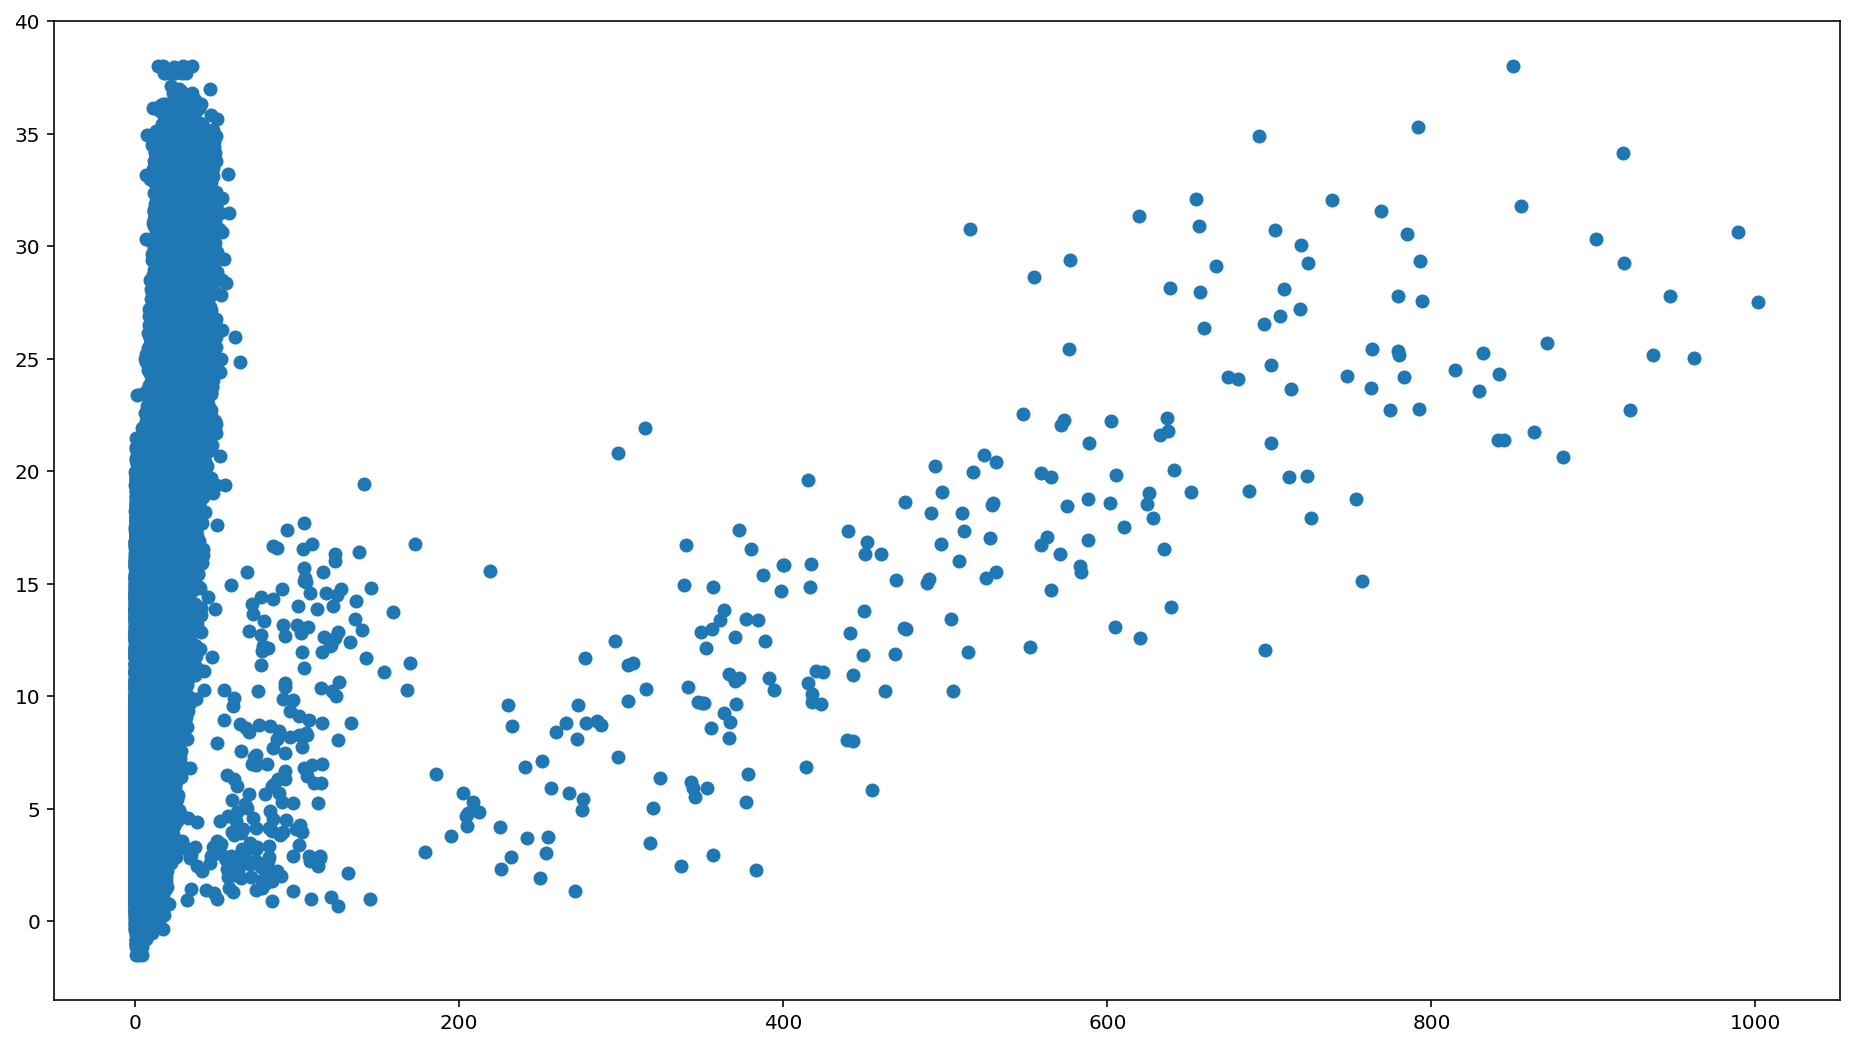

In [356]:
plot_pred_actual(LinearRegression())

In [364]:
poly_model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                       ('linear', LinearRegression(fit_intercept=False))])

{'whiskers': [<matplotlib.lines.Line2D at 0x1375d2e10>,
 'caps': [<matplotlib.lines.Line2D at 0x1375d7a20>,
 'boxes': [<matplotlib.lines.Line2D at 0x1375d27b8>],
 'medians': [<matplotlib.lines.Line2D at 0x1375d7cc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1375da320>],
 'means': []}

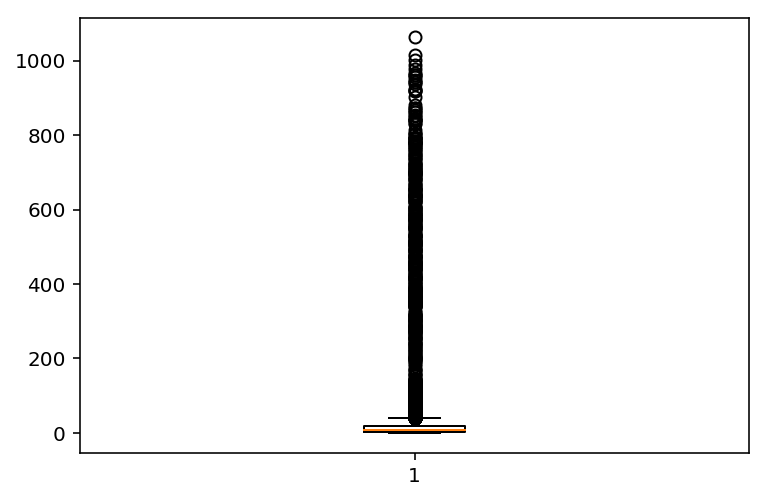

In [375]:
plt.boxplot(learning_df['amount'])

In [381]:
learning_df['amount'].describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

In [11]:
Q3 = np.percentile(learning_df['amount'],75)
Q1 = np.percentile(learning_df['amount'],25)
IQR = Q3-Q1
upper_limit = Q3 + 1.5*IQR
upper_limit

41.004999999999995

In [12]:
learning_df_IQR = learning_df.loc[learning_df['amount']<=upper_limit,:]
learning_df_IQR.shape

(137717, 18)

In [13]:
X_train_IQR, X_test_IQR, y_train_IQR, y_test_IQR = create_train_test_split(learning_df_IQR)
scaler_IQR = MinMaxScaler()
X_train_IQR = scaler_IQR.fit_transform(X_train_IQR)
X_test_IQR = scaler_IQR.transform(X_test_IQR)

Training MSE: 39.63003503687678
Testing MSE: 39.45555022224974


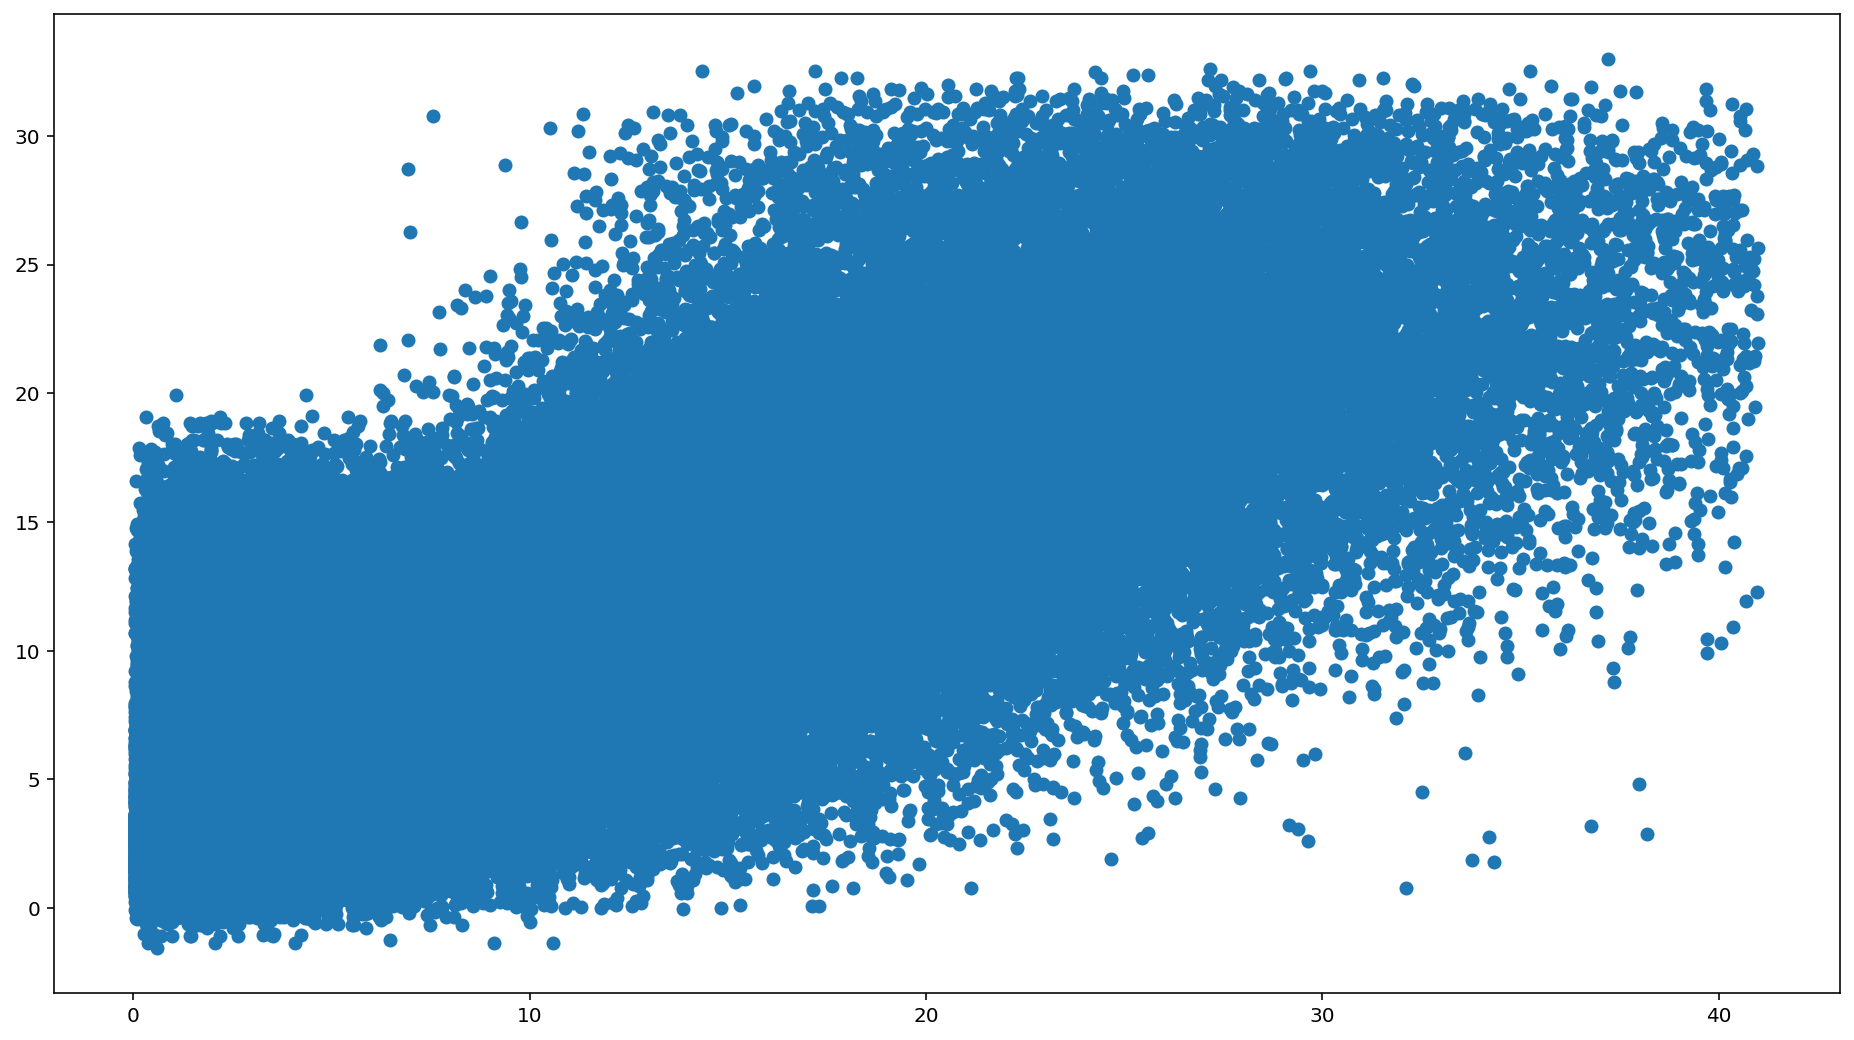

In [14]:
plot_pred_actual(LinearRegression(), X_train_IQR, X_test_IQR, y_train_IQR, y_test_IQR)

Training MSE: 12.450668318738762
Testing MSE: 27.516281834865797


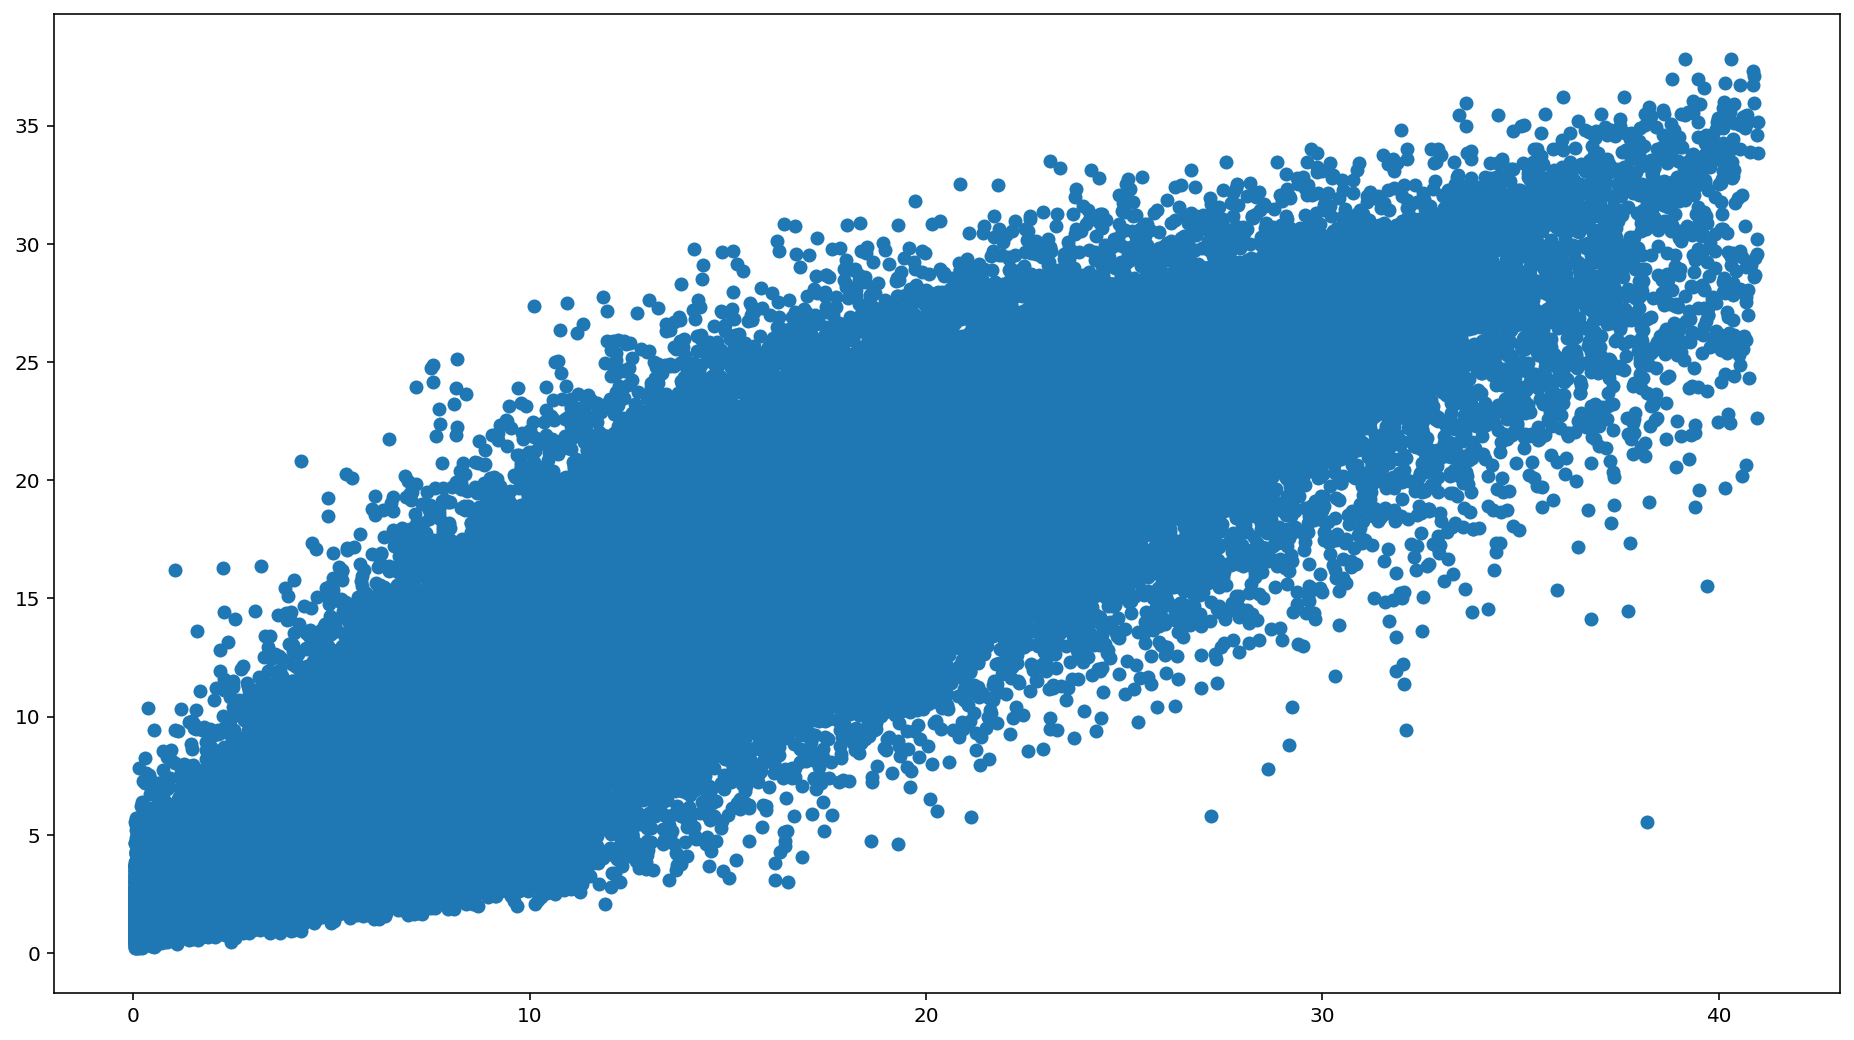

In [15]:
plot_pred_actual(RandomForestRegressor(n_estimators=100), X_train_IQR, X_test_IQR, y_train_IQR, y_test_IQR)

Training MSE: 37.53793711749128
Testing MSE: 37.34712108187887


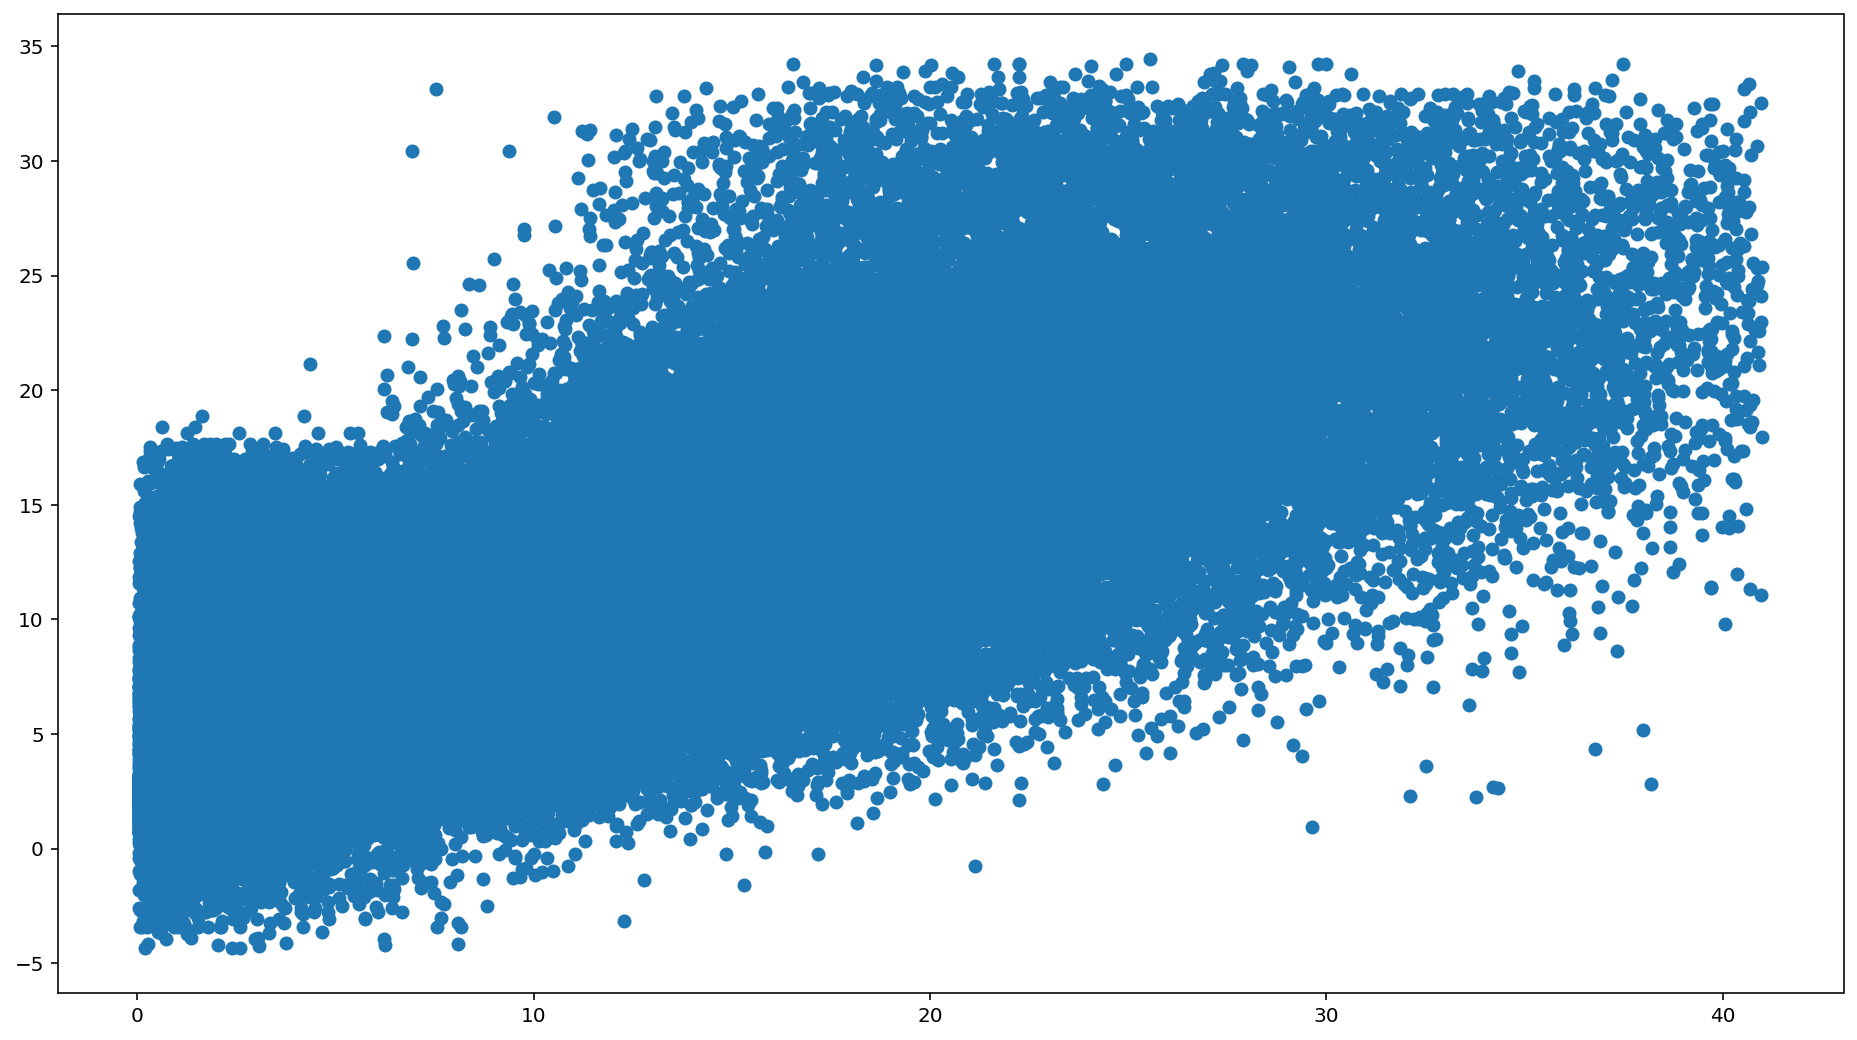

In [21]:
poly_model2 = Pipeline([('poly', PolynomialFeatures(degree=2)),
                       ('linear', LinearRegression(fit_intercept=False))])
plot_pred_actual(poly_model2, X_train_IQR, X_test_IQR, y_train_IQR, y_test_IQR)

Training MSE: 35.63556448171289
Testing MSE: 9.02664169643495e+19


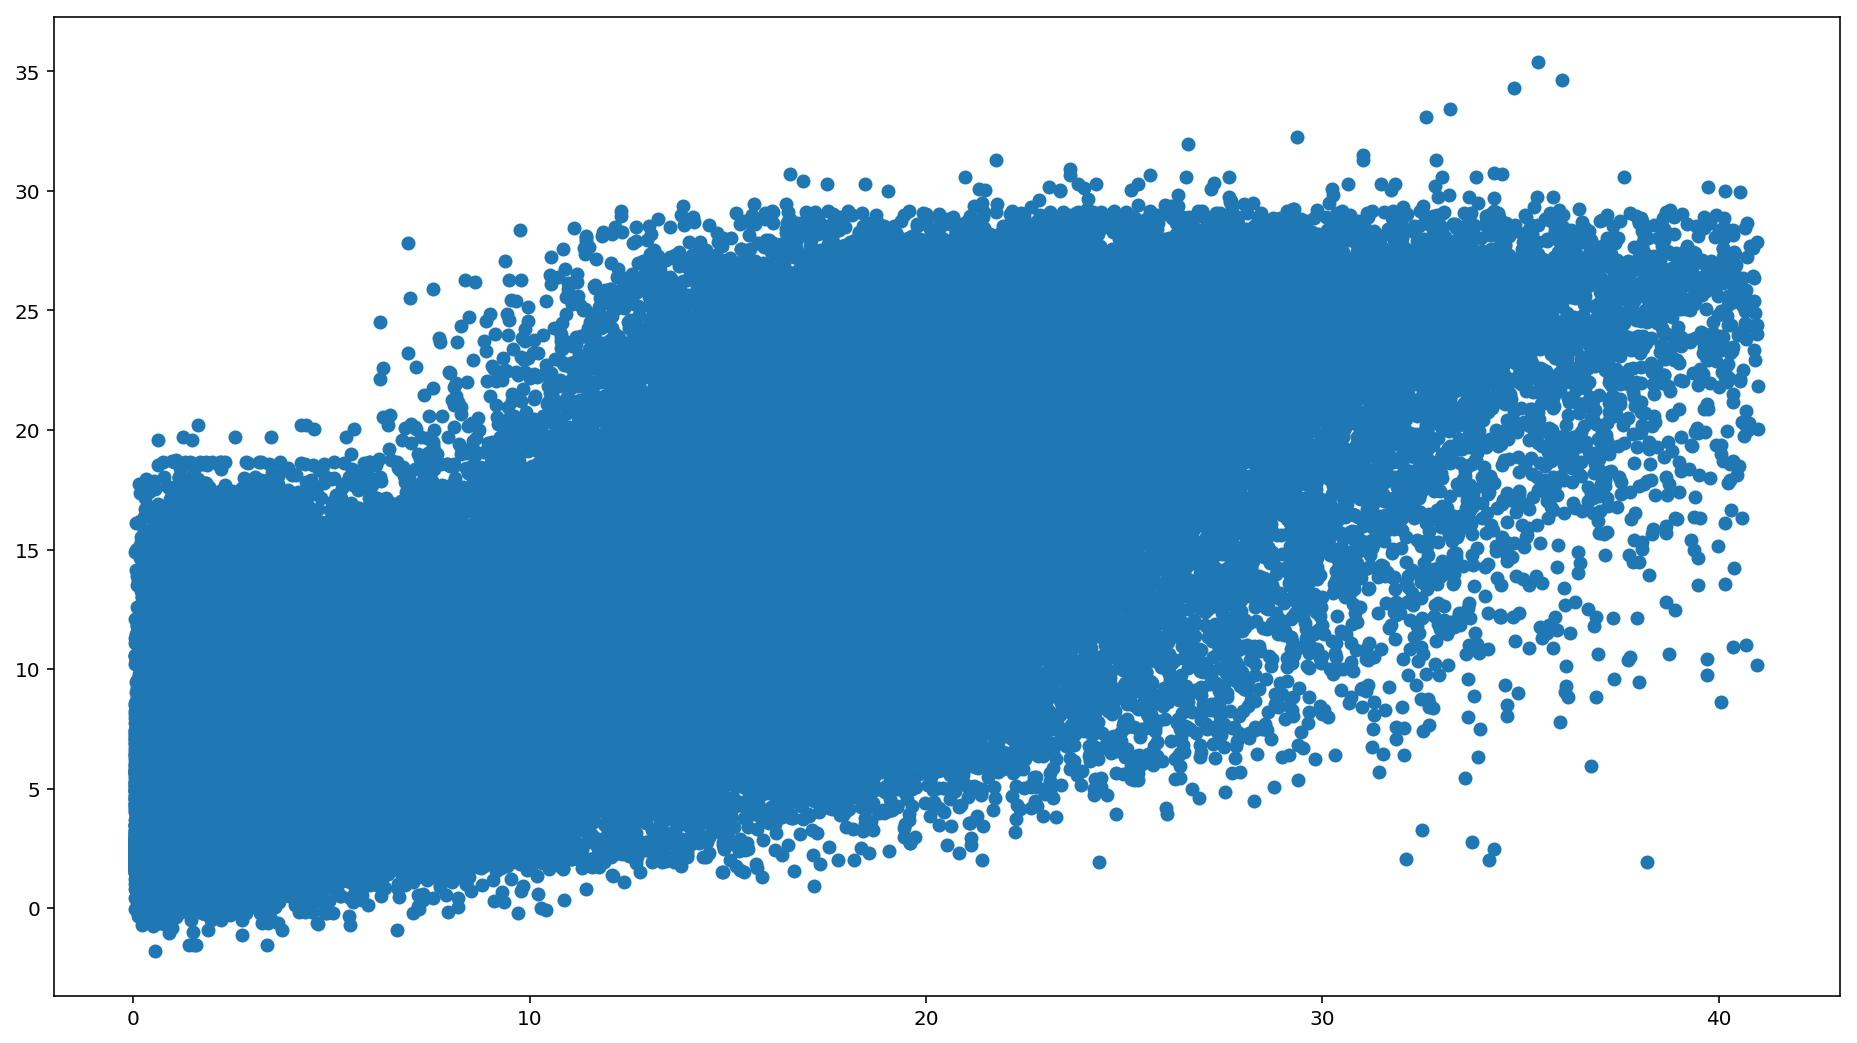

In [396]:
poly_model3 = Pipeline([('poly', PolynomialFeatures(degree=3)),
                       ('linear', LinearRegression(fit_intercept=False))])
plot_pred_actual(poly_model3, X_train_IQR, X_test_IQR, y_train_IQR, y_test_IQR)

Training MSE: 12.517553344126917
Testing MSE: 28.64847616945635


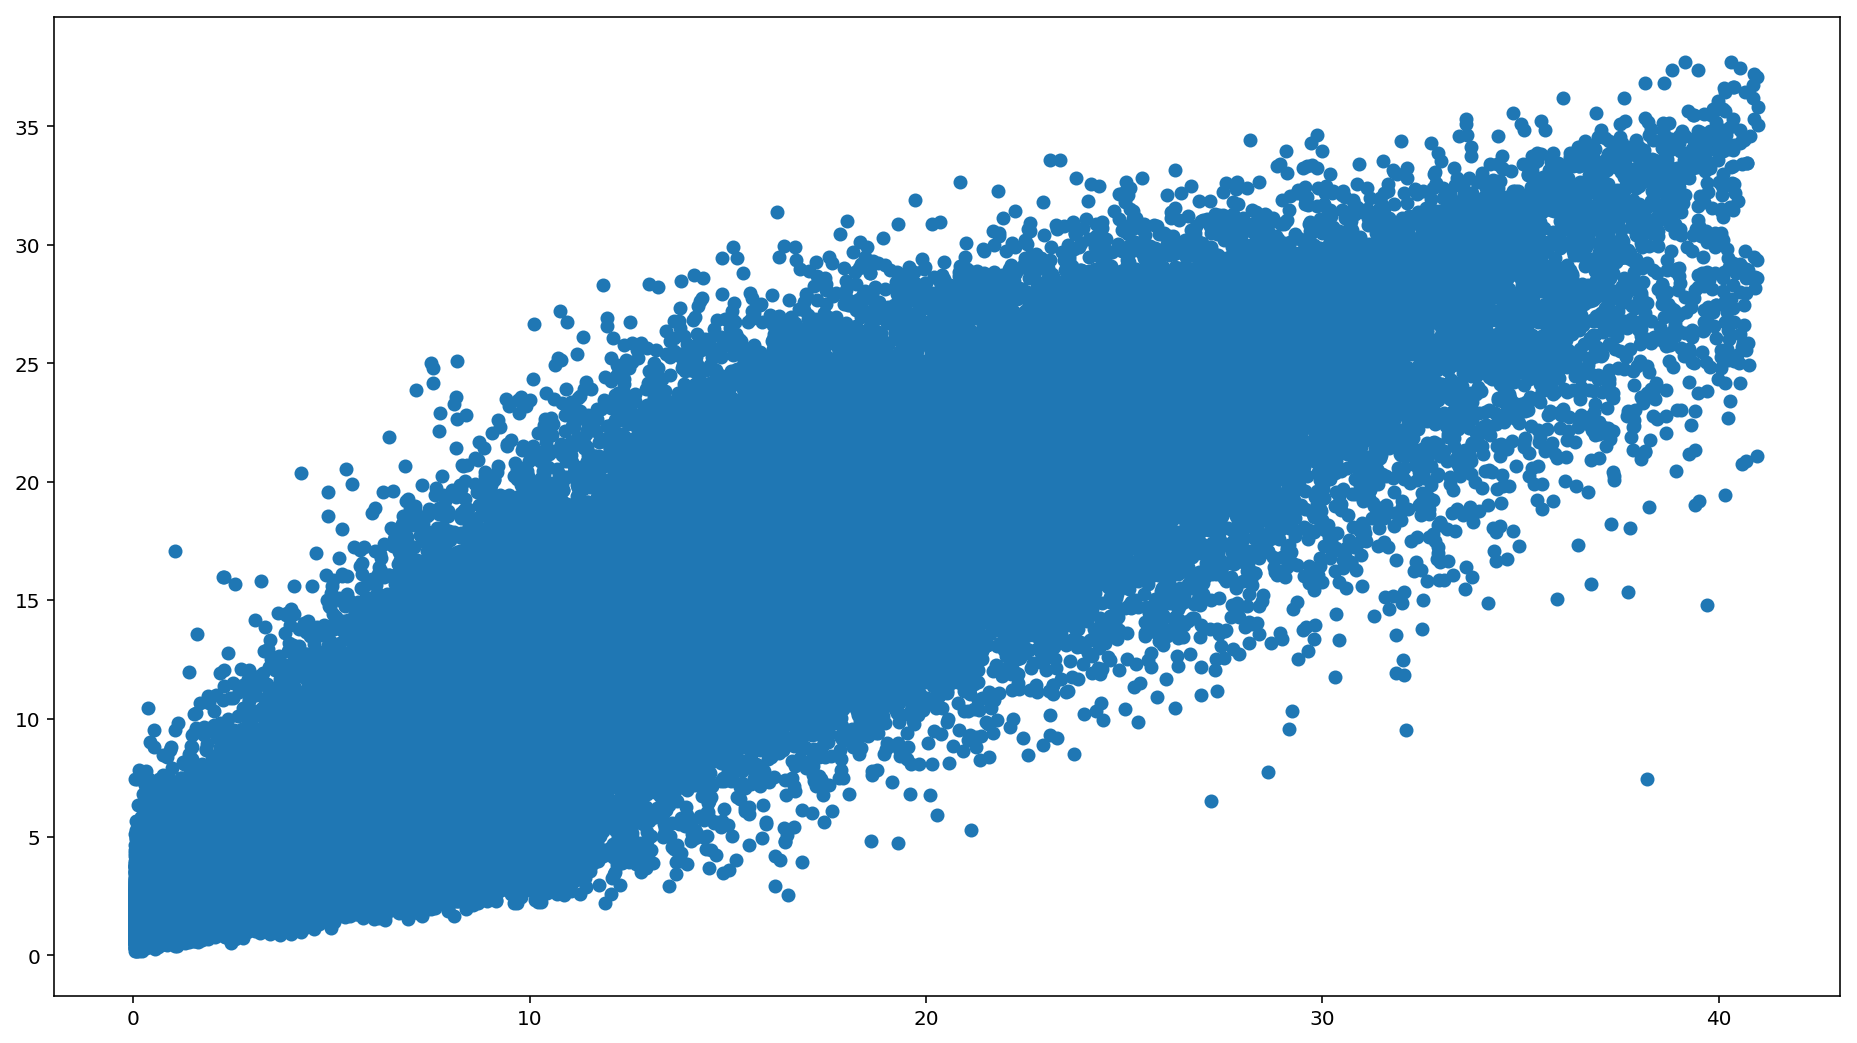

In [397]:
poly_model2 = Pipeline([('poly', PolynomialFeatures(degree=2)),
                       ('forest', RandomForestRegressor(n_estimators=100))])
plot_pred_actual(poly_model2, X_train_IQR, X_test_IQR, y_train_IQR, y_test_IQR)

Training MSE: 15.577613105885717
Testing MSE: 26.23293009674386


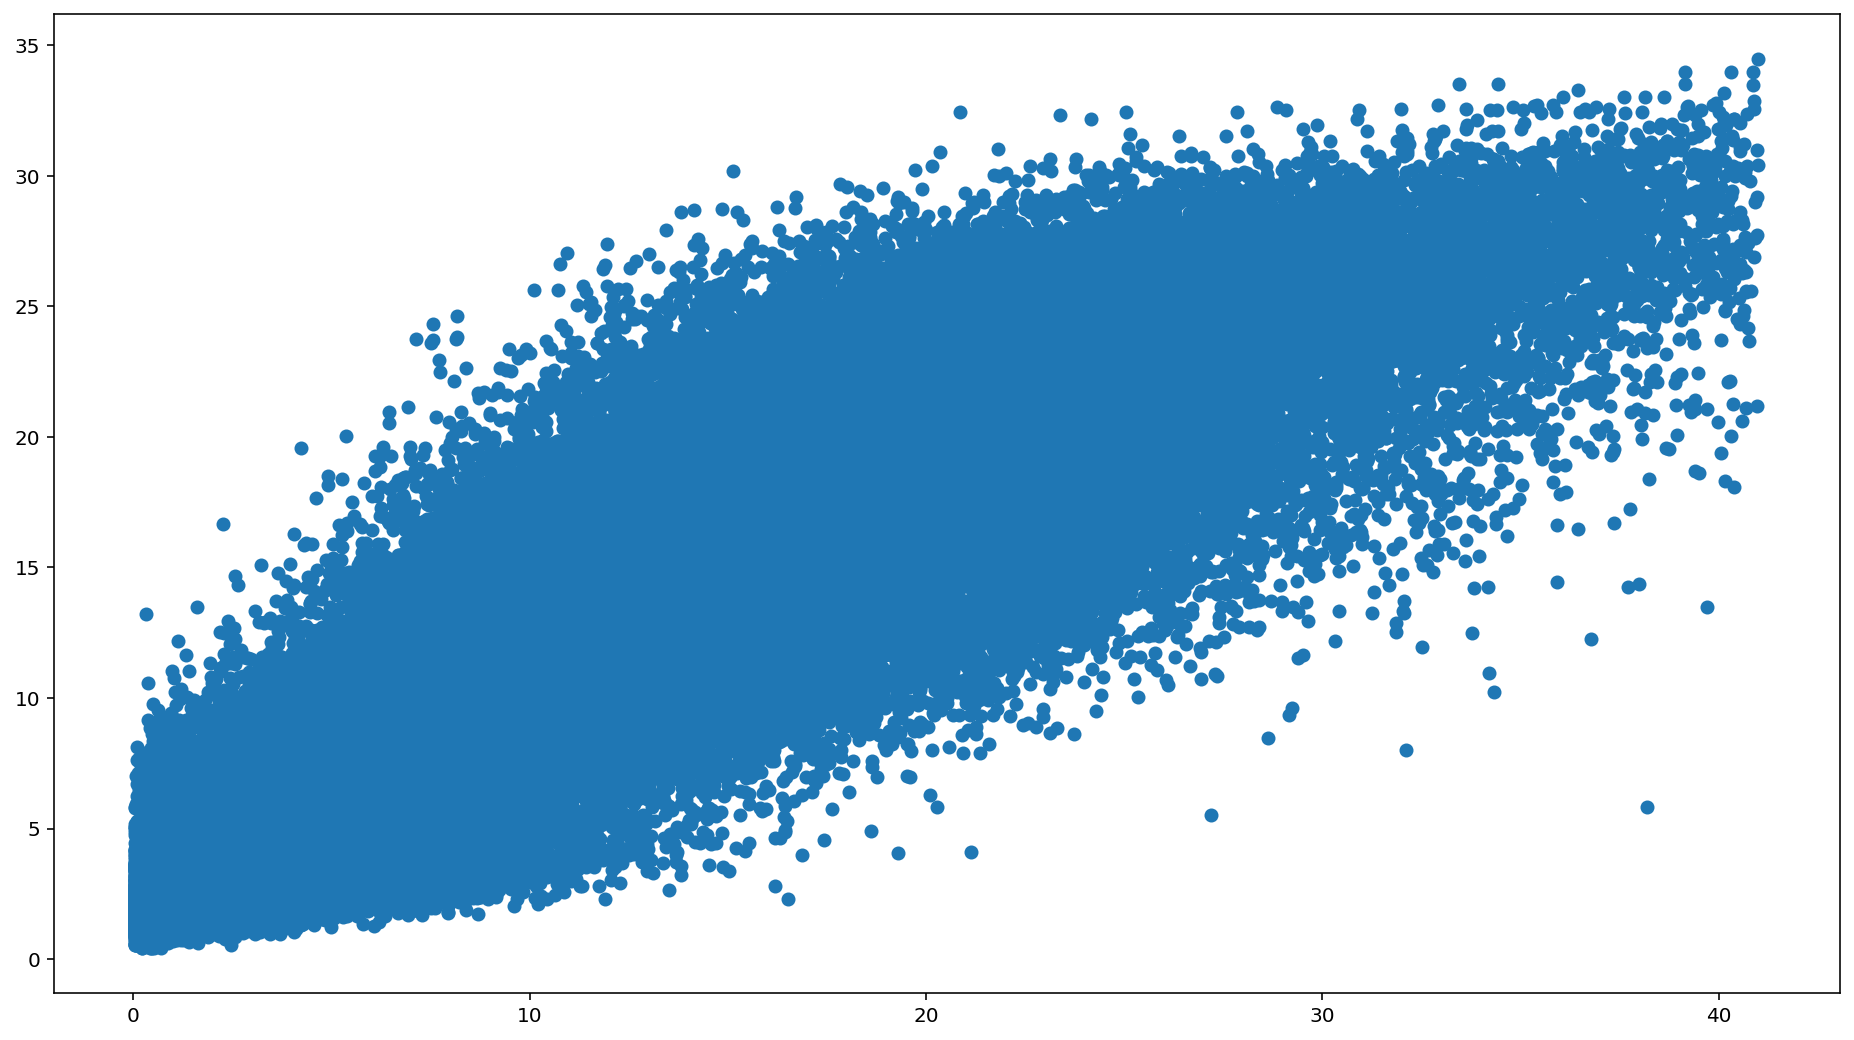

In [17]:
plot_pred_actual(BaggingRegressor(n_estimators=100,max_samples=.4), X_train_IQR, X_test_IQR, y_train_IQR, y_test_IQR)

Training MSE: 15.596846052276511
Testing MSE: 26.443726964446103


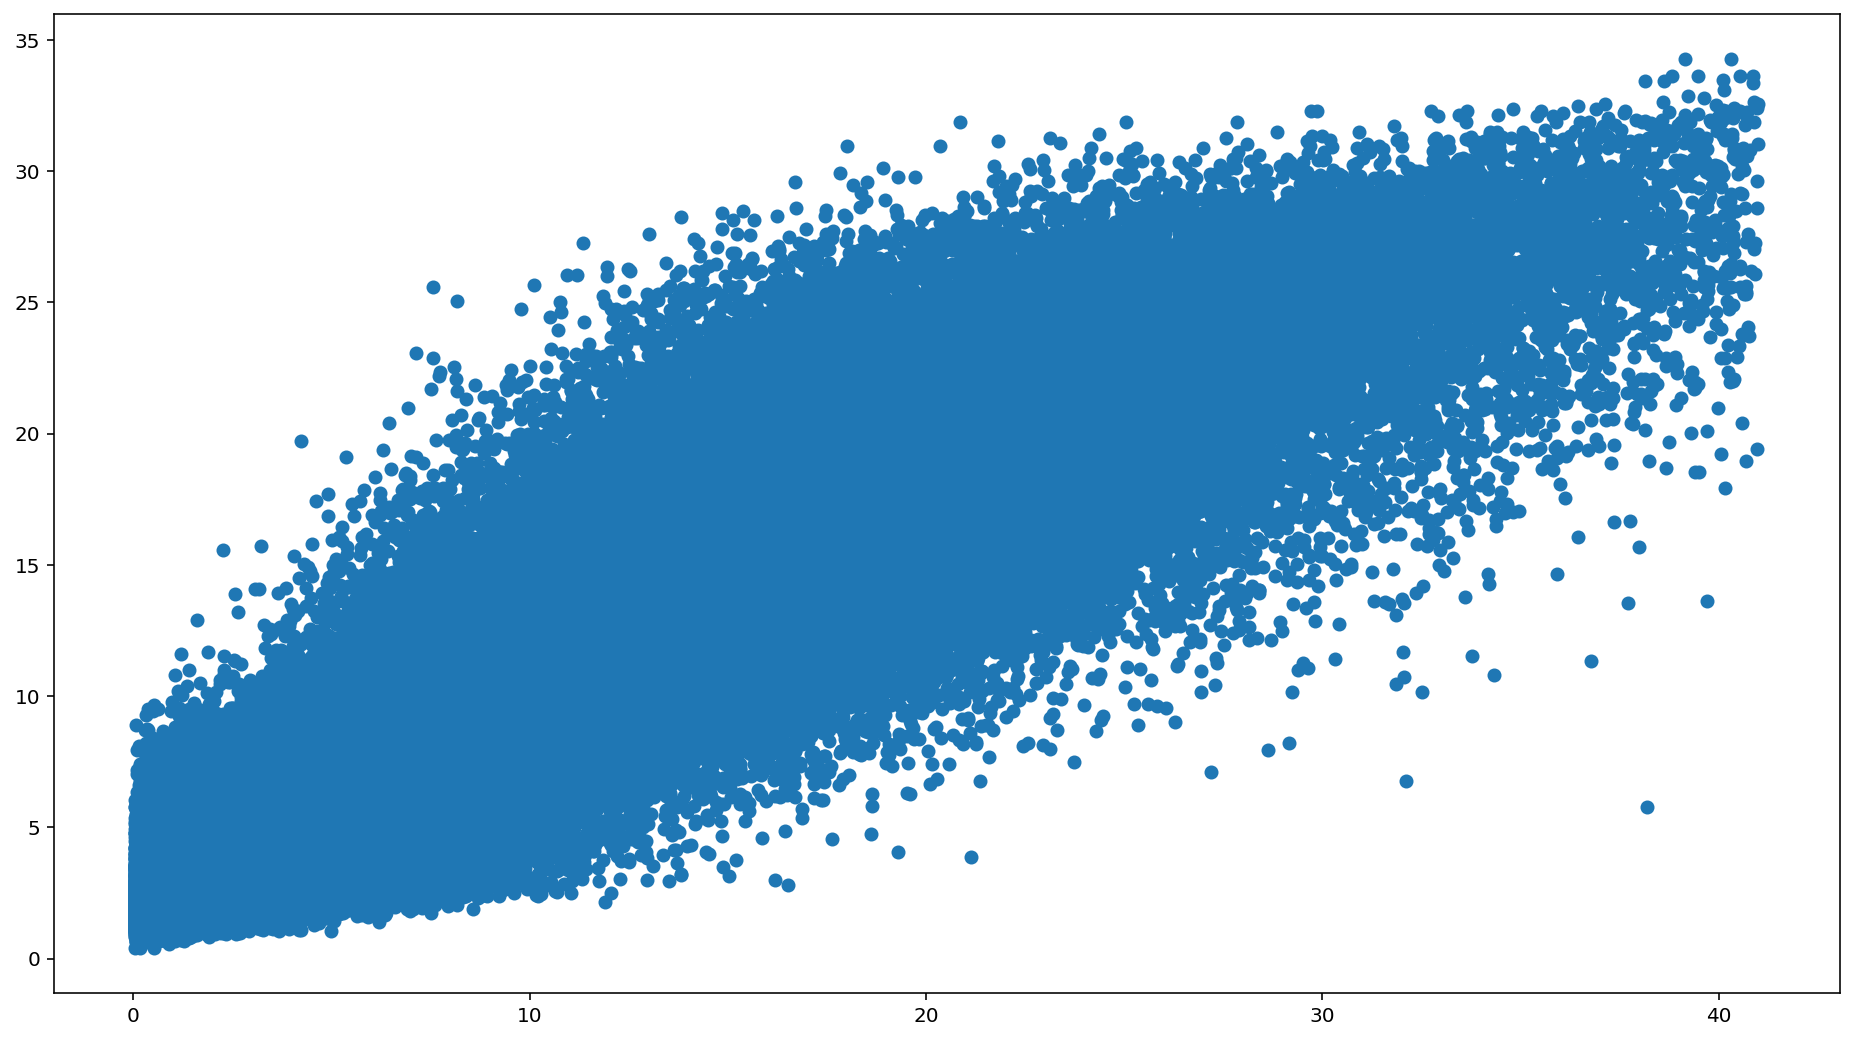

In [18]:
reg1=LinearRegression()
reg2=RandomForestRegressor(n_estimators=100)
reg3=BaggingRegressor(n_estimators=100,max_samples=0.4)
voter = VotingRegressor([('lr',reg1),('rf',reg2),('bg',reg3)],[.2,.4,.4])
plot_pred_actual(voter, X_train_IQR, X_test_IQR, y_train_IQR, y_test_IQR)

Training MSE: 39.79217655271712
Testing MSE: 39.608325004450776


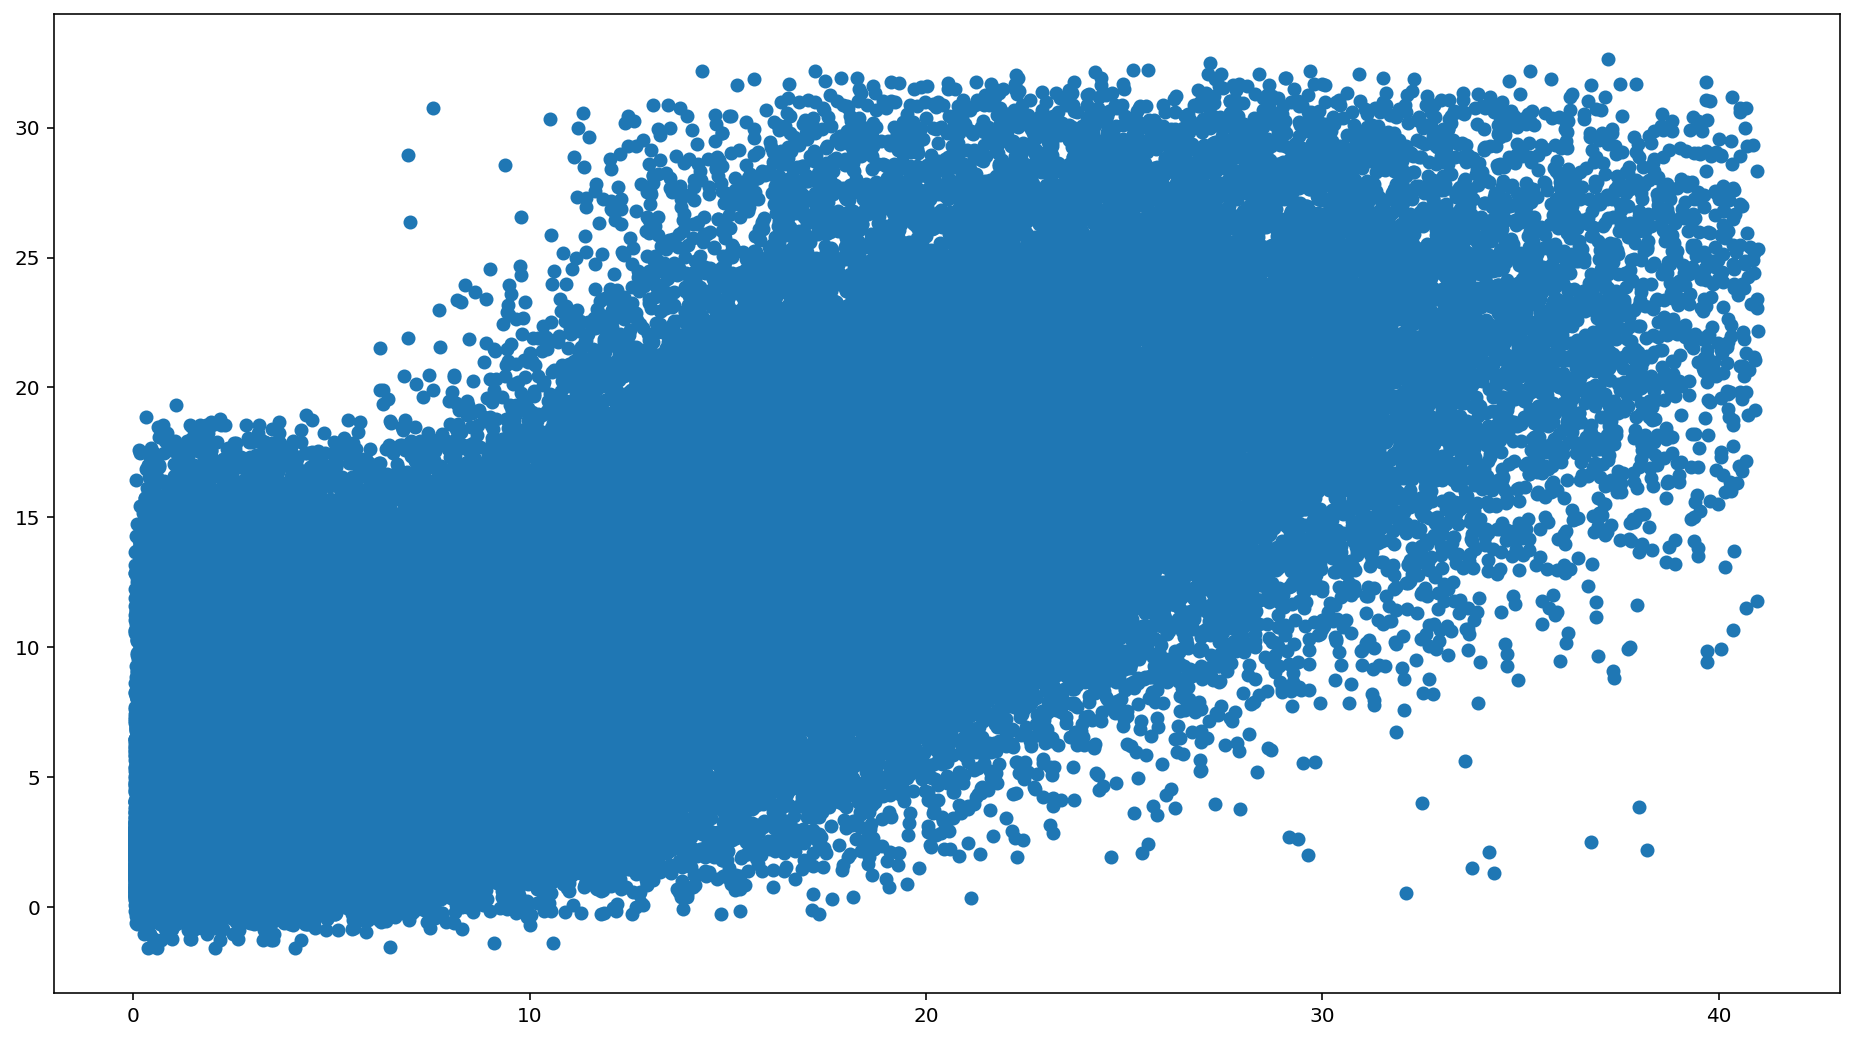

In [14]:
plot_pred_actual(LinearSVR(), X_train_IQR, X_test_IQR, y_train_IQR, y_test_IQR)

Training MSE: 39.63802132397131
Testing MSE: 39.47245387611572


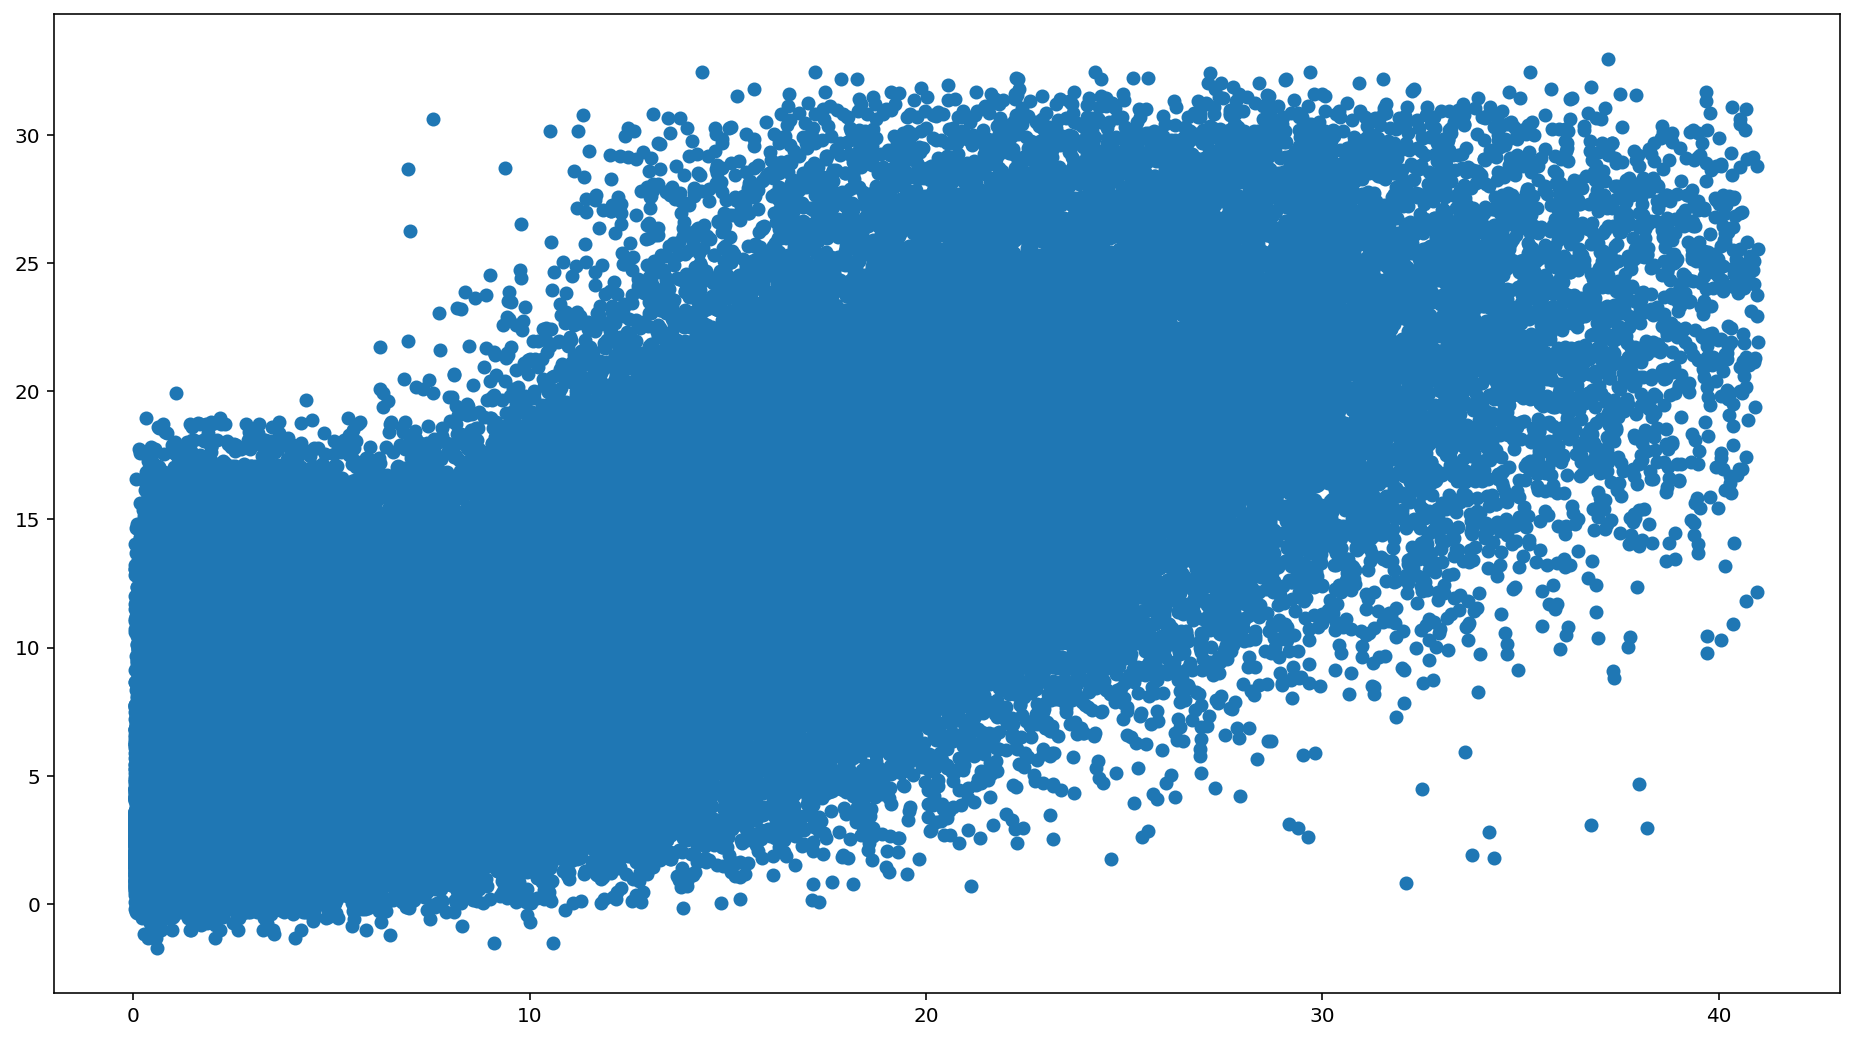

In [15]:
plot_pred_actual(SGDRegressor(), X_train_IQR, X_test_IQR, y_train_IQR, y_test_IQR)

Training MSE: 15.485548781054652
Testing MSE: 26.171305820439585


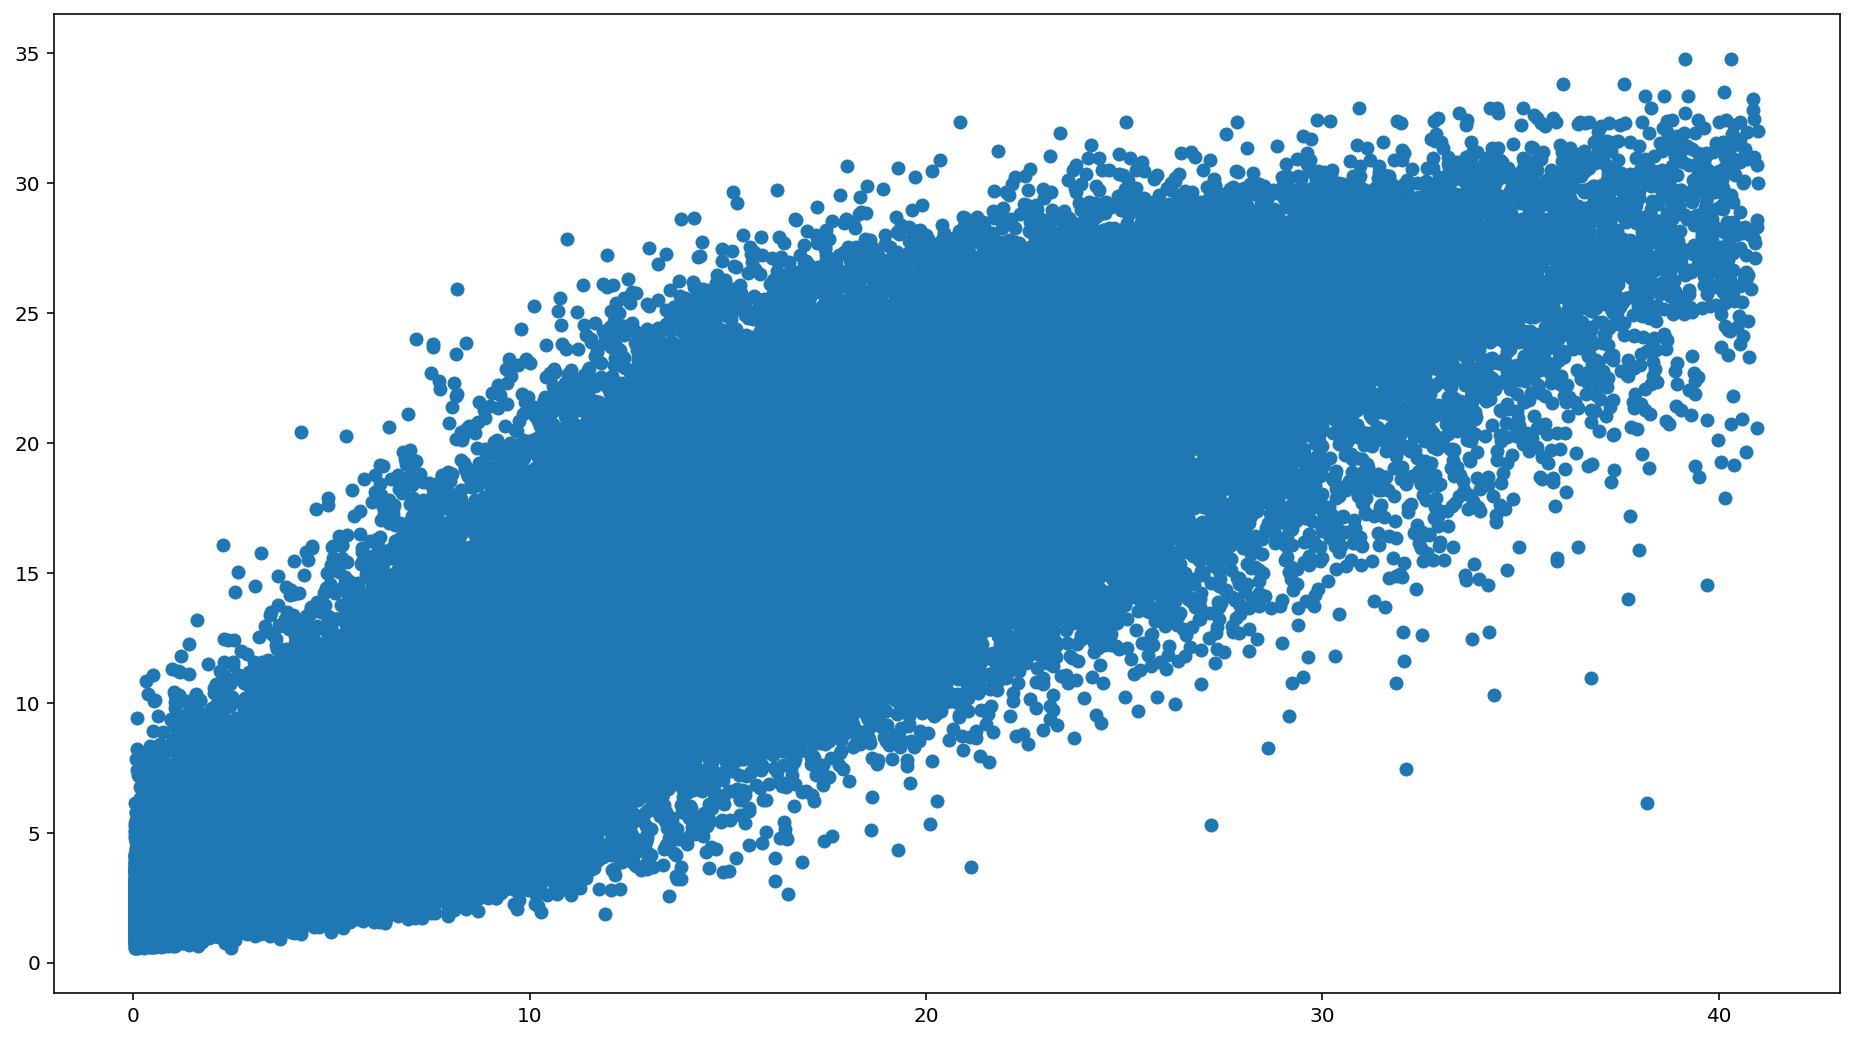

In [16]:
plot_pred_actual(BaggingRegressor(n_estimators=200,max_samples=.4), X_train_IQR, X_test_IQR, y_train_IQR, y_test_IQR)

Training MSE: 15.907297653510385
Testing MSE: 27.692663810732874


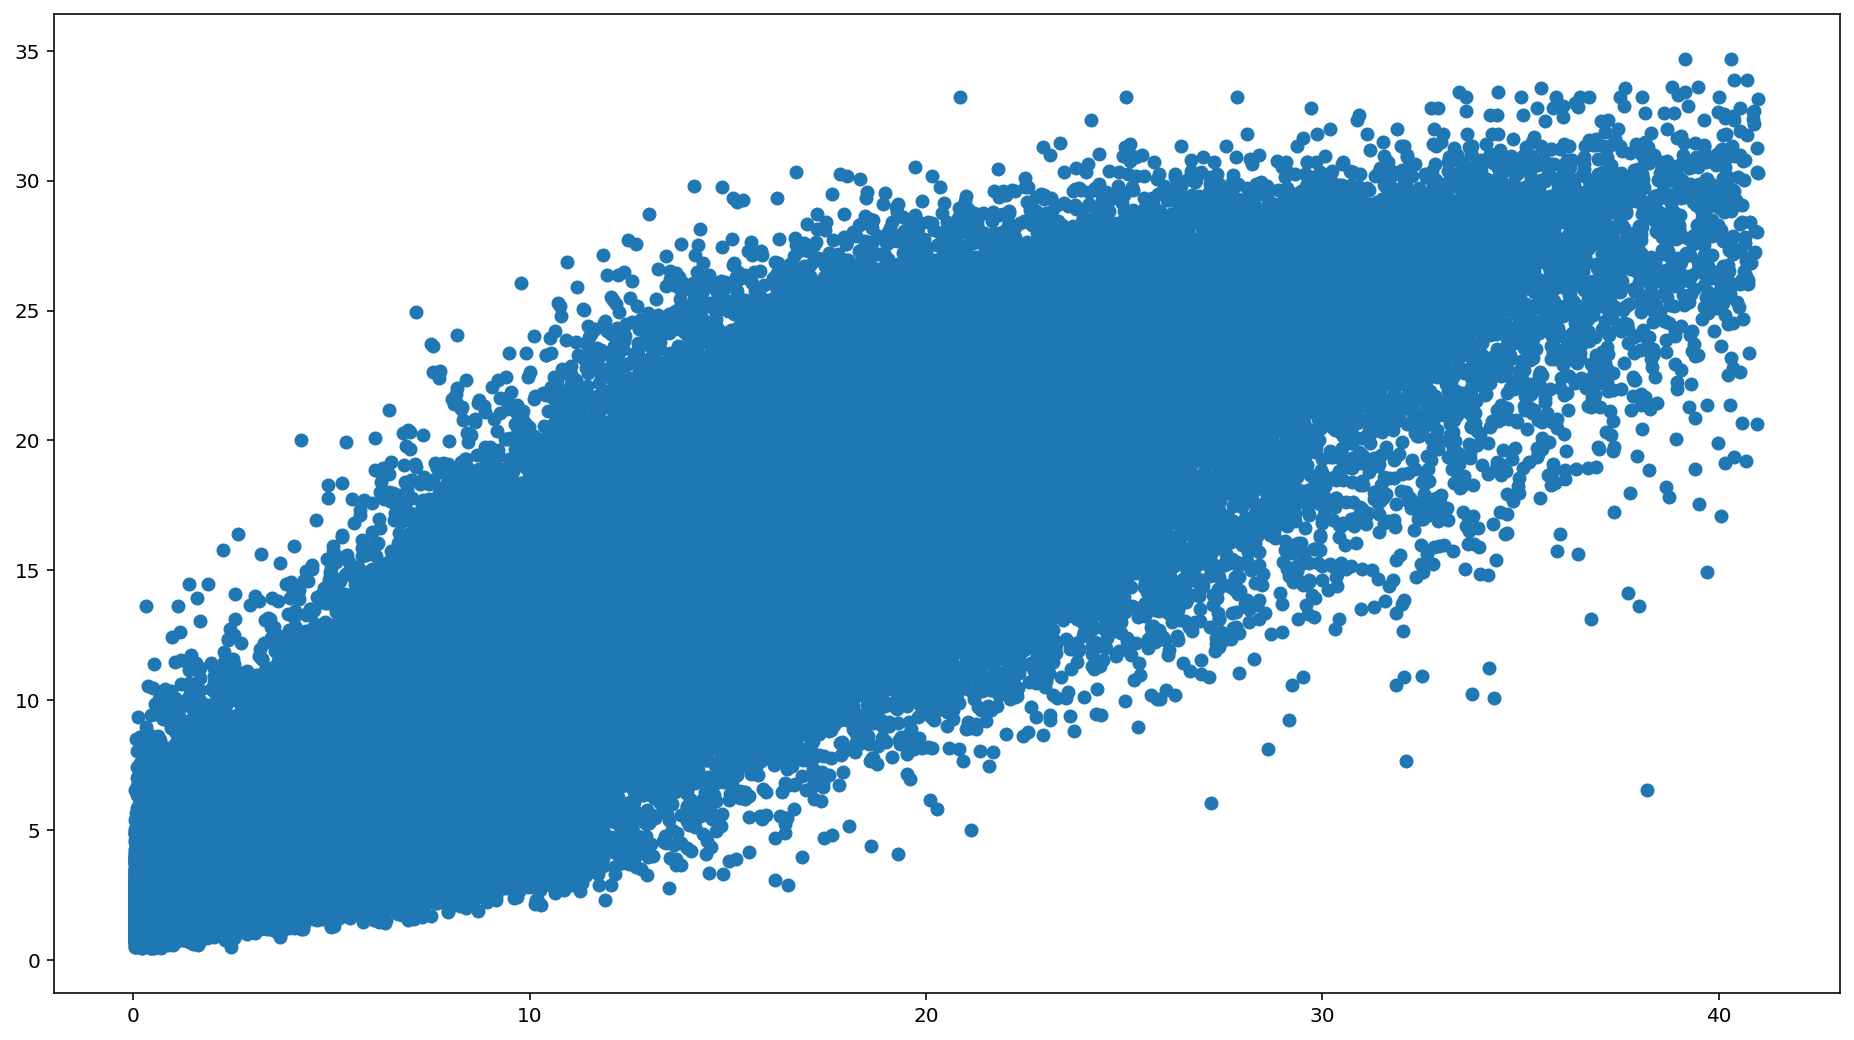

In [17]:
poly_model2 = Pipeline([('poly', PolynomialFeatures(degree=2)),
                       ('bg', BaggingRegressor(n_estimators=100,max_samples=.4))])
plot_pred_actual(poly_model2, X_train_IQR, X_test_IQR, y_train_IQR, y_test_IQR)